#### Laurent Jutras-Dubé

## The 3-gene models: deterministic simulations

####   


**1. Pattern formation with the 3-gene models**

In this notebook, we perform deterministic simulations of the 3-gene models. See the Methods and Supplement for a description of the models.

In [1]:
%matplotlib notebook
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'figure.max_open_warning': 0})

####     

**1.1 The ODEs**

In the following code cell, we define functions for the ODEs describing the dynamics of the 3 proteins, named arbitrarily $A$, $B$, and $C$. The dynamic term encodes repressilator dynamics, while the static term encodes a tristable system via mutual repression. We also include a degradation term. The weights of the dynamic and static terms are quadratic in Model 1, and linear in Model 2. We specify the values of all parameters later in this notebook.

In [2]:
def dynamic(conc, param):
    
    A = conc[:,0]
    B = conc[:,1]
    C = conc[:,2]
    K = param["K"]
    n = param["n"]
       
    dA = 1./(1.+(B/K)**n)
    dB = 1./(1.+(C/K)**n)
    dC = 1./(1.+(A/K)**n)
    
    return np.array([dA, dB, dC]).transpose()



def static(conc, param):
    
    A = conc[:,0]
    B = conc[:,1]
    C = conc[:,2]
    K = param["K"]
    n = param["n"]
       
    dA = 1./(1.+(B/K)**n) *1./(1.+(C/K)**n)
    dB = 1./(1.+(C/K)**n) *1./(1.+(A/K)**n)
    dC = 1./(1.+(A/K)**n) *1./(1.+(B/K)**n)
    
    return np.array([dA, dB, dC]).transpose()



def dconc(conc, g, param):
    
    g = np.array([g, g, g]).transpose()
    ng = param["ng"]
    
    return g**ng*dynamic(conc, param) +(1.-g)**ng*static(conc, param) -conc

####  

**1.2 The morphogen gradient**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed, we make $t^*(x)$ a linear function of $x$, via the `positions` vector and the `v` parameter. In other words, we model a gradient of $g$ with a fixed steepness that moves in the posterior direction at a constant rate. We generate a kymograph showing the spatio-temporal profile of $g$ later in this notebook.

In [3]:
def compute_g(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The integration scheme**

We use the Euler integration scheme to perform the integration of the ODEs. The `integrate` function requires two inputs: the initial concentration of the 3 genes at all spatial positions, and the dictionary of parameters. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasing this parameter can help reduce the size of the three output matrices, `results`, `g_gradient` and `times_plot`. These matrices respectively contain the concentration of the 3 genes at all positions for every time point, the spatio-temporal distribution of parameter $g$ and the array of times. 

In [4]:
def integrate(init_conc, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)

    conc = init_conc
    results = [conc]
    g = compute_g(0., param)
    g_gradient = [g]
    times_plot = [0.]
    
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]
    
    derivative = dconc
    if param["Hill_weights"]:    derivative = dconc_Hill

    
    # Perform the integration
    for t in times[1:]:
        
        conc = conc +derivative(conc, g, param)*dt
        conc[conc < 0.] = 0.
        
        g = compute_g(t, param)
           
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(conc)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

####  

**1.4 The kymograph plots**

We visualize the results with a kymograph where the $x$ axis is time and the $y$ axis is the position of the cell along the tissue. We represent the concentration of the genes with a purple to blue to white color scheme, where white (blue and purple, resp.) means that gene $A$ ($B$ and $C$, resp.) is predominant in that cell at that time. A cell that contains a mix of the three genes appears grey on the kymograph.

We plot lines representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely $0.5$ and $0.2$. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

In [5]:
def compute_x(g, t, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s -x_osc +v*t



def compute_t(g, x, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return (x_osc +x -np.log(g)/s)/v
    

    
def plot_kymograph(results, g_gradient, times_plot, title, param):
    
    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()
    norm = colors.Normalize(vmin=0., vmax=1.)
    
    # Kymograph
    ax.imshow(results[:,:,1].transpose(), norm=norm, cmap='PuBu', aspect='auto')
    kymo = ax.imshow(results[:,:,2].transpose(), norm=norm, cmap='BuPu', aspect='auto', alpha=0.5)
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
    cb.ax.tick_params(labelsize=24)
    cb.ax.set_yticklabels(['A', 'B', 'C'])
    
    # Lines of constant g
    ax.plot(param["n_cells"]*compute_x(1., times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='k', rotation=-70, fontsize=24)
    ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-70, fontsize=24)
    ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-70, fontsize=24)
    
    # Other plot options
    ax.set_title(title, fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()

####  

**1.5 The dynamics of pattern formation in Models 1 and 2**

We define all the required parameters for the ODEs, the morphogen gradient and the integration. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. In Model 1, we set parameter `ng` to 2, while in Model 2, we set `ng` to 1.

<IPython.core.display.Javascript object>


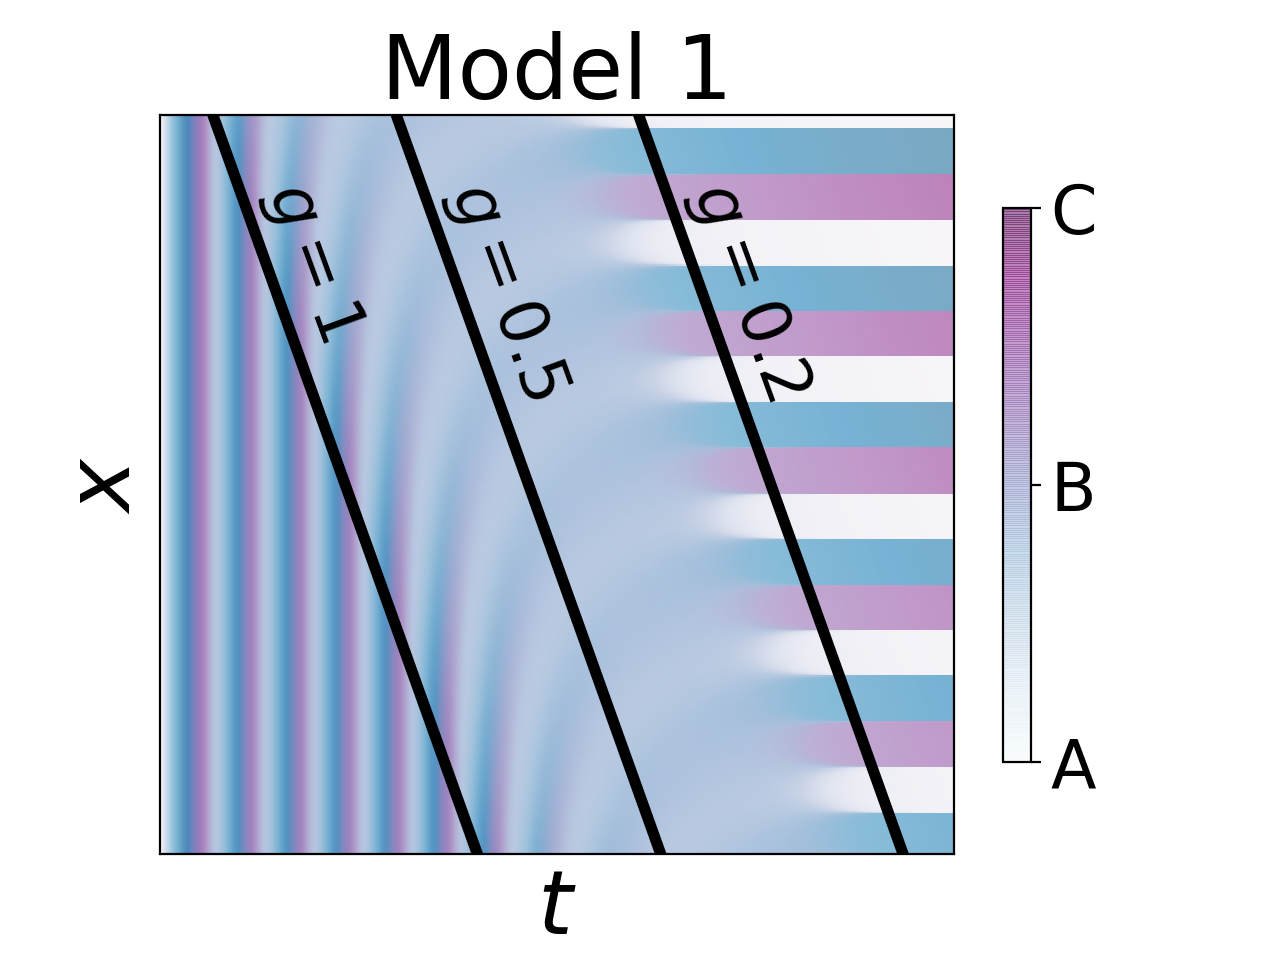

<IPython.core.display.Javascript object>


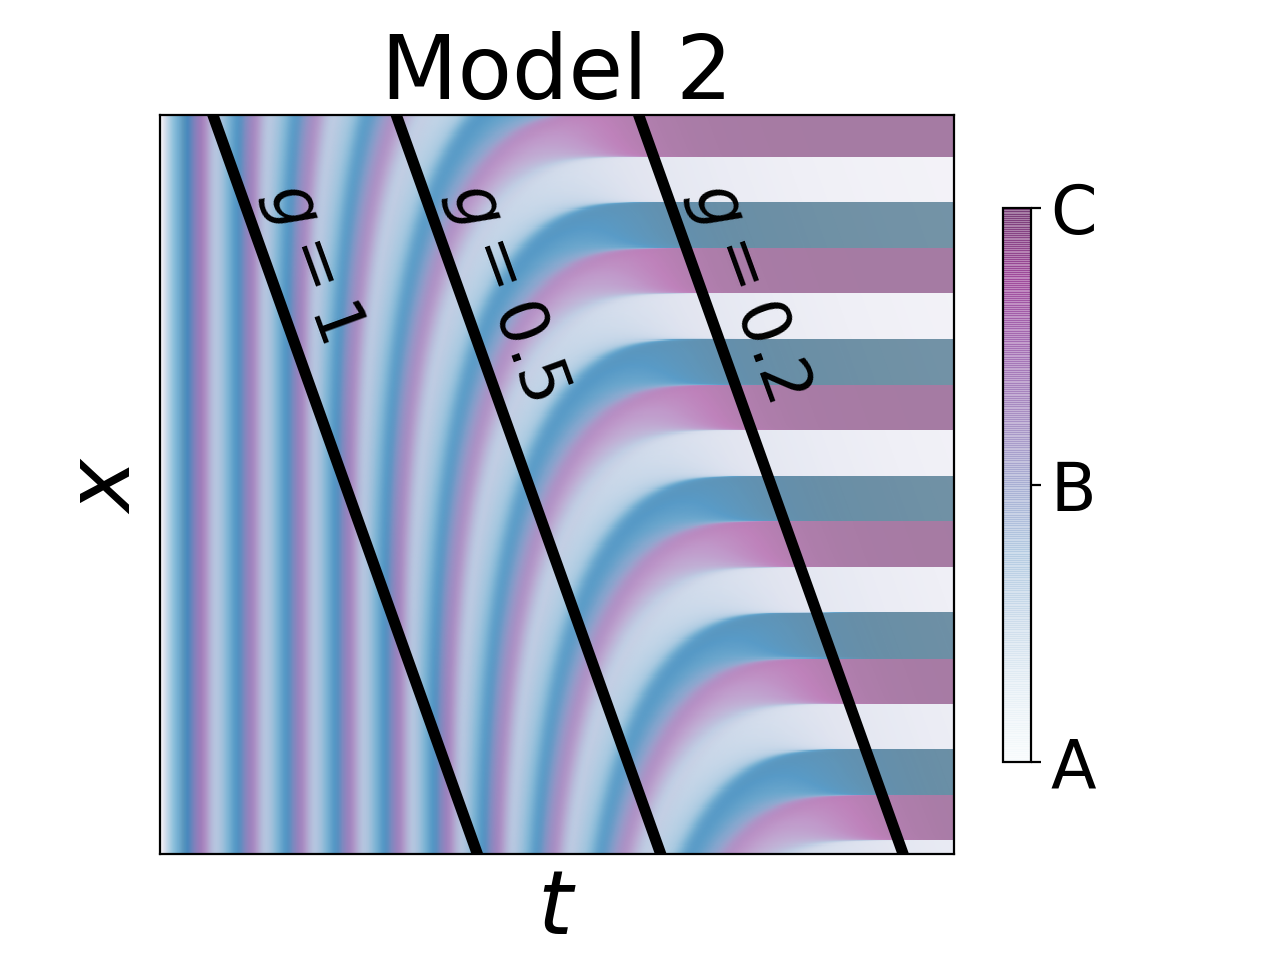

In [6]:
param ={
    
    # ODE parameters
    "K"  : 0.4,
    "n"  : 5,
    "ng" : 2,
    
    # Morphogen gradient parameters
    "x_osc"   : 0.2,
    "s"       : 1.,
    "v"       : 0.05,
    "n_cells" : 700,
    
    # Integration parameters
    "total_t"                : 60.,
    "dt"                     : 0.01,
    "n_steps_keep_results"   : 1,
    
    # Hill functions for the weights
    "Hill_weights" : False,
    "Hill_dyn"  : 0.6,
    "Hill_stat" : 0.4
}


init_conc = np.zeros((param["n_cells"], 3))
init_conc[:,0] = 0.75


# Model 1
param["ng"] = 2
results_m1, g_gradient_m1, times_plot_m1 = integrate(init_conc, param)
plot_kymograph(results_m1, g_gradient_m1, times_plot_m1, 'Model 1', param)


# Model 2
param["ng"] = 1
results_m2, g_gradient_m2, times_plot_m2 = integrate(init_conc, param)
plot_kymograph(results_m2, g_gradient_m2, times_plot_m2, 'Model 2', param)

On both kymographs, we clearly see the well-defined pattern obtained at the end of the simulation, and the slowing down of the oscillations in single cells. For Model 1, we also see that all cells reach a similar gene expression state for values of $g$ around 0.5. This is due to the Hopf bifurcation that transforms the genetic oscillations into a single stable gene expression state. We generate the bifurcation diagram for both versions of the model in the next section of this notebook.

In the next code cell, we plot the concentration of all genes in a single cell as a function of time for both versions of the model. We choose arbitrarily the most anterior cell.

<IPython.core.display.Javascript object>


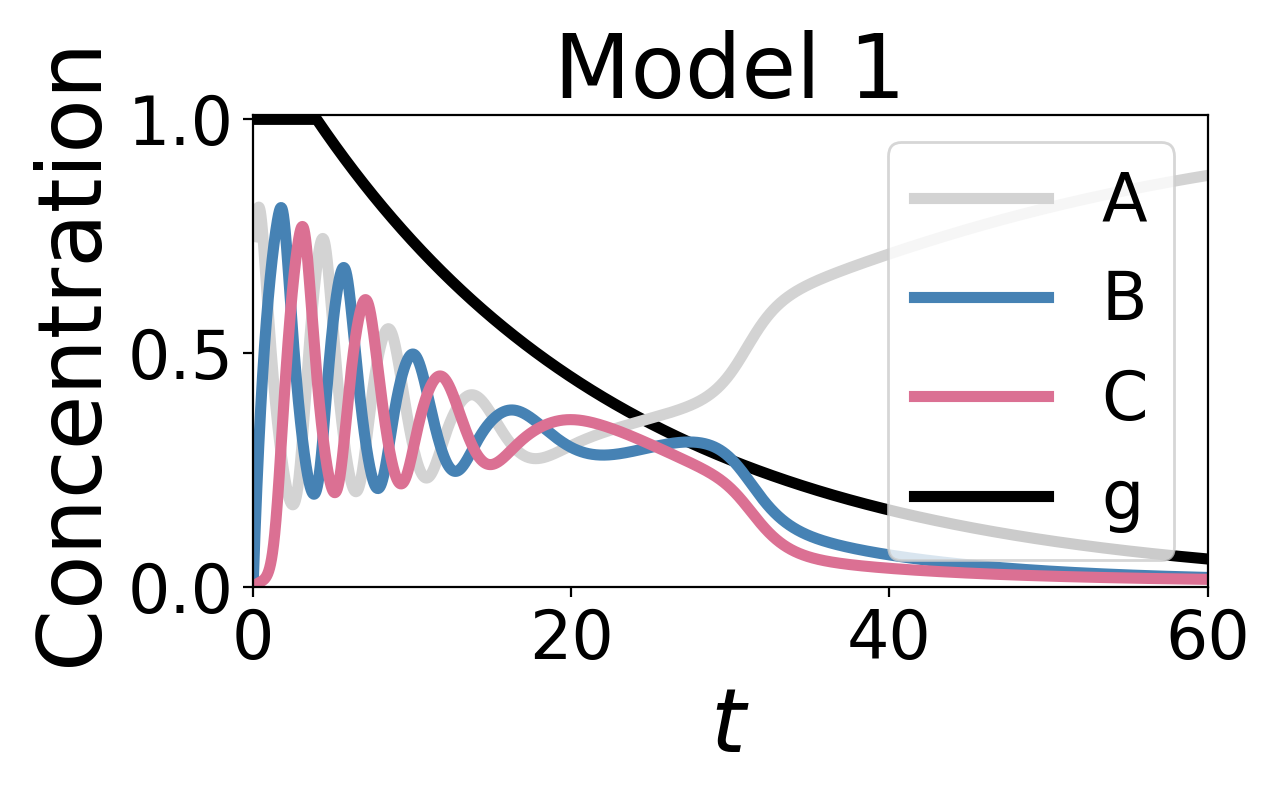

<IPython.core.display.Javascript object>


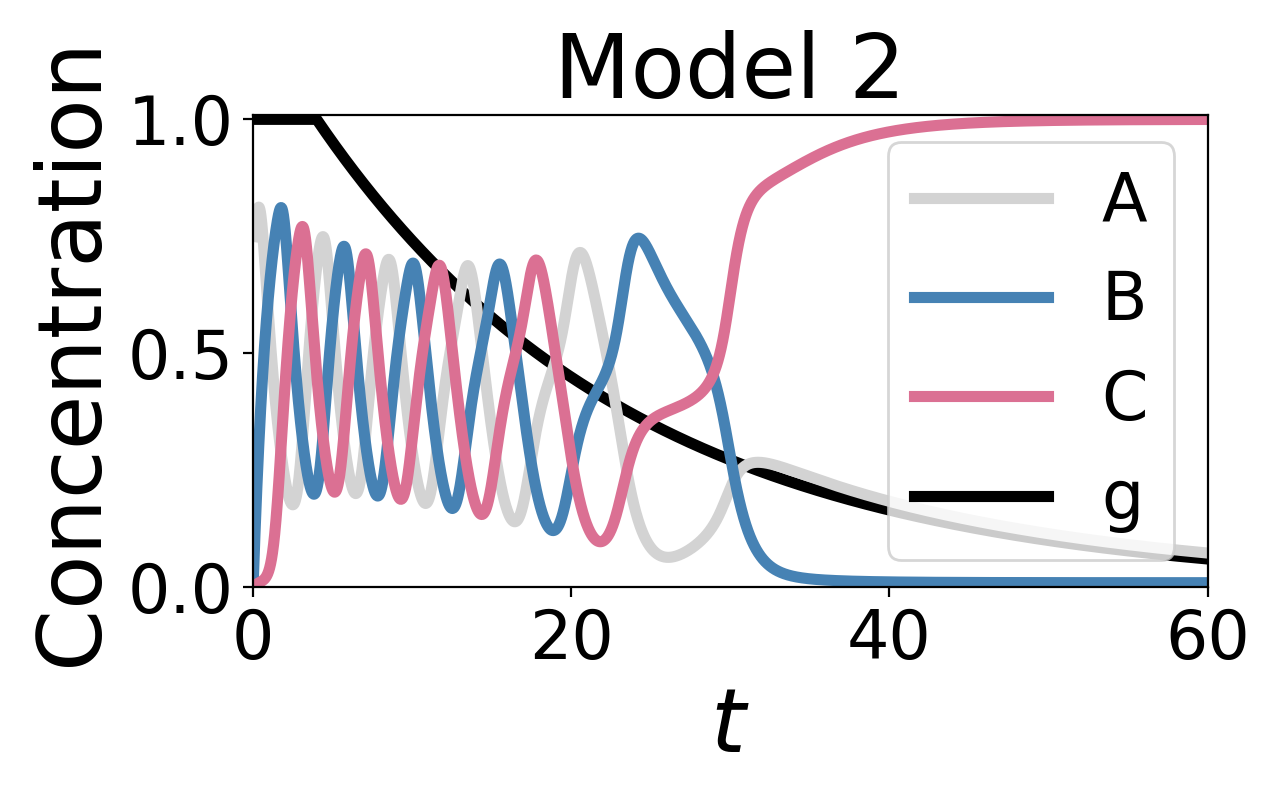

In [7]:
position_m1 = 0
position_m2 = 0


# Model 1
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_m1, results_m1[:, position_m1, 0], color='lightgrey', lw=4, label='A')
ax.plot(times_plot_m1, results_m1[:, position_m1, 1], color='steelblue', lw=4, label='B')
ax.plot(times_plot_m1, results_m1[:, position_m1, 2], color='palevioletred', lw=4, label='C')
ax.plot(times_plot_m1, g_gradient_m1[:, position_m1], color='k', lw=4, label='g', zorder=0)

# Plot options
ax.set_title('Model 1', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([0., 60.])
ax.set_ylim([0., 1.01])
        
fig.tight_layout()
fig.show()



# Model 2
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_m2, results_m2[:, position_m2, 0], color='lightgrey', lw=4, label='A')
ax.plot(times_plot_m2, results_m2[:, position_m2, 1], color='steelblue', lw=4, label='B')
ax.plot(times_plot_m2, results_m2[:, position_m2, 2], color='palevioletred', lw=4, label='C')
ax.plot(times_plot_m2, g_gradient_m2[:, position_m2], color='k', lw=4, label='g', zorder=0)

# Plot options
ax.set_title('Model 2', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([0., 60.])
ax.set_ylim([0., 1.01])
        
fig.tight_layout()
fig.show()

####   

In the next code cell, we generate a kymograph showing the spatio-temporal profile of $g$.

<IPython.core.display.Javascript object>


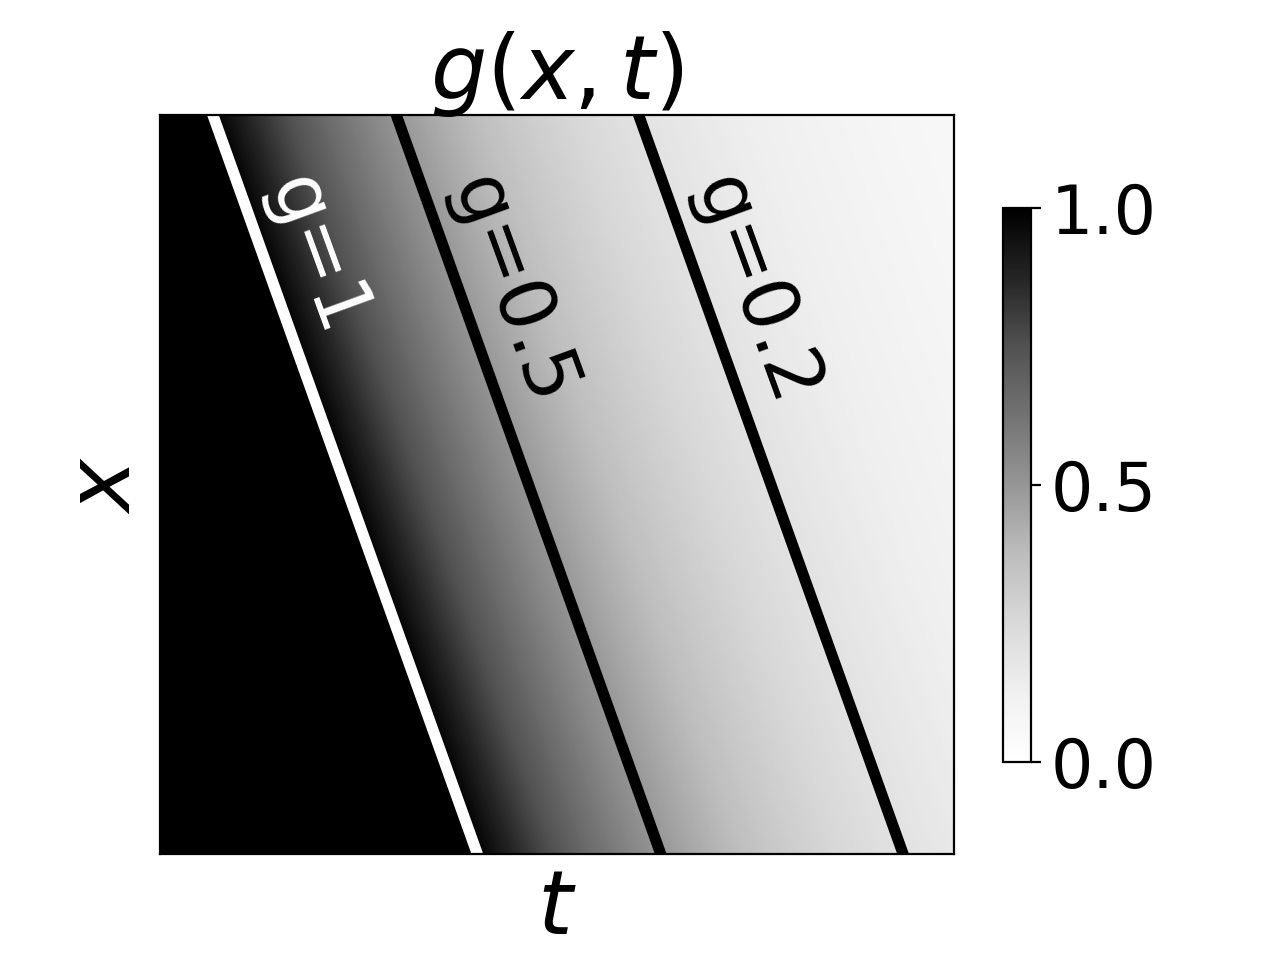

In [8]:
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_gradient_m1.transpose(), norm=norm, cmap='Greys', aspect='auto')
    
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
    
# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times_plot_m1, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times_plot_m1, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times_plot_m1, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=1', color='w', rotation=-70, fontsize=28)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=0.5', rotation=-70, color='k', fontsize=28)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=0.2', rotation=-70, color='k', fontsize=28)
    
# Other plot options 
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####   

In the following code cell, we visualise the weights of the dynamic and static modules for both Model 1 and Model 2.

<IPython.core.display.Javascript object>


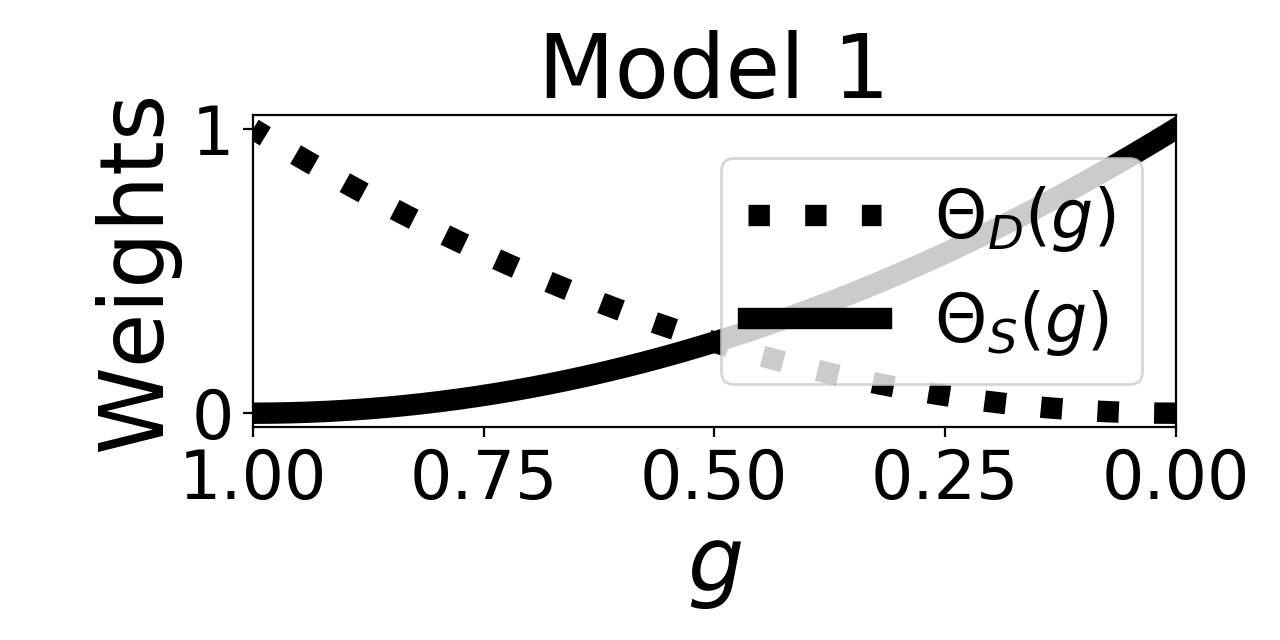

<IPython.core.display.Javascript object>


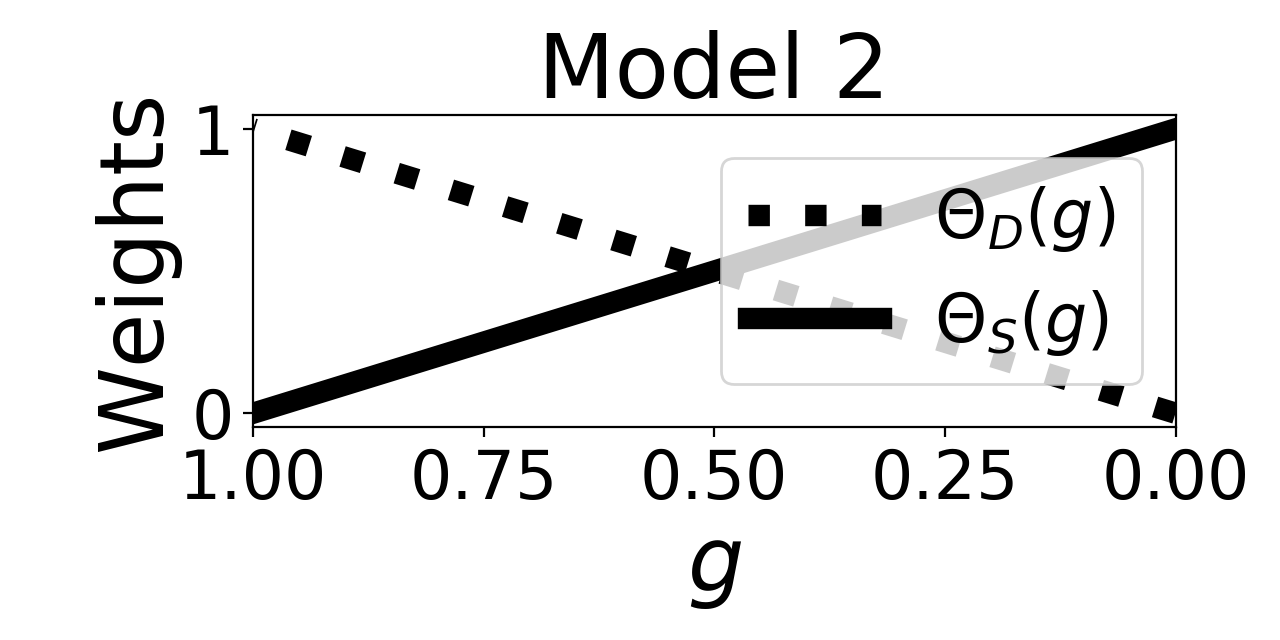

In [9]:
# Model 1
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g, g*g, c='k', ls=':', lw=7.7, label='$\Theta_D(g)$')
ax.plot(g, (1.-g)*(1.-g), c='k', ls='-', lw=7.7, label='$\Theta_S(g)$')

# Plot options
ax.set_title('Model 1', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=5).set_zorder(20)

fig.tight_layout()
fig.show()



# Model 2
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g, g, c='k', ls=':', lw=7.7, label='$\Theta_D(g)$')
ax.plot(g, (1.-g), c='k', ls='-', lw=7.7, label='$\Theta_S(g)$')

# Plot options
ax.set_title('Model 2', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=5).set_zorder(20)

fig.tight_layout()
fig.show()

####  

**1.6 The dynamics of pattern formation in 3-gene models with Hill functions for the weights**

To verify that these results do not depend on the specific functions describing the weights of the dynamic and static modules, we repeat the same procedure with Hill functions for the weights, instead of polynomials. To recover the Hopf bifurcation of Model 1, we set the Hill treshold of the dynamic module `Hill_dyn` to 0.6. To get the SNIC bifurcation of Model 2, we set `Hill_dyn` to 0.4. In both models, we set the Hill threshold of the static module `Hill_stat` to 0.4.

First, we define a new `dconc_Hill` function that describes the dynamics inside a single cell. Then, we plot the kymographs of the dynamics of gene expression for both models and typical trajectories of single cells. We also plot a kymograph of the dynamics of $g$. Finally, we visualise the weights of the dynamic and static modules.

In [10]:
def dconc_Hill(conc, g, param):
    
    g = np.array([g, g, g]).transpose()
    n = param["n"]
    Hill_dyn = param["Hill_dyn"]
    Hill_stat = param["Hill_stat"]
    
    return (g/Hill_dyn)**n/(1.+(g/Hill_dyn)**n)*dynamic(conc, param) +1./(1.+(g/Hill_stat)**n)*static(conc, param) -conc

<IPython.core.display.Javascript object>


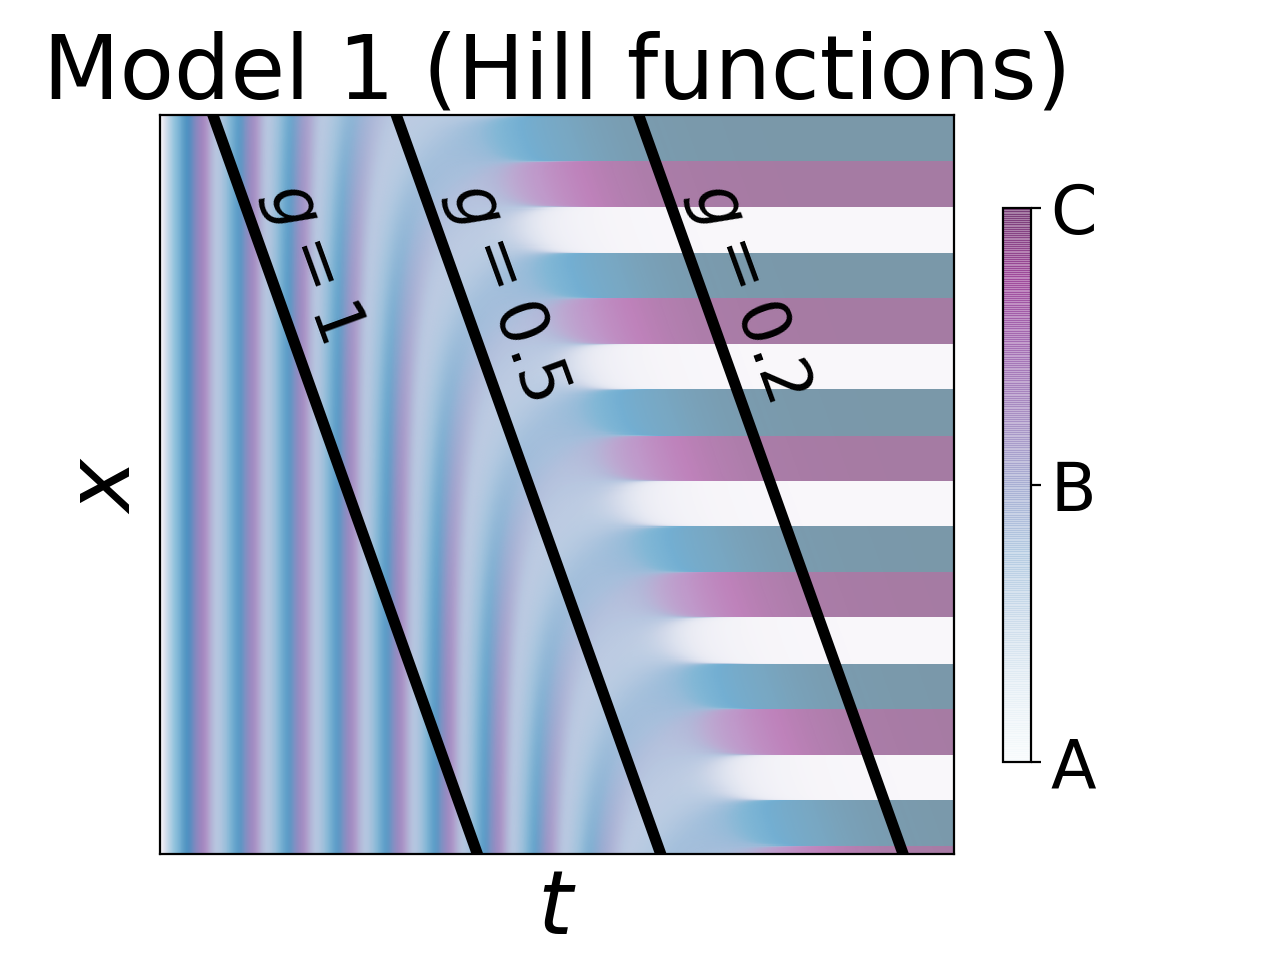

<IPython.core.display.Javascript object>


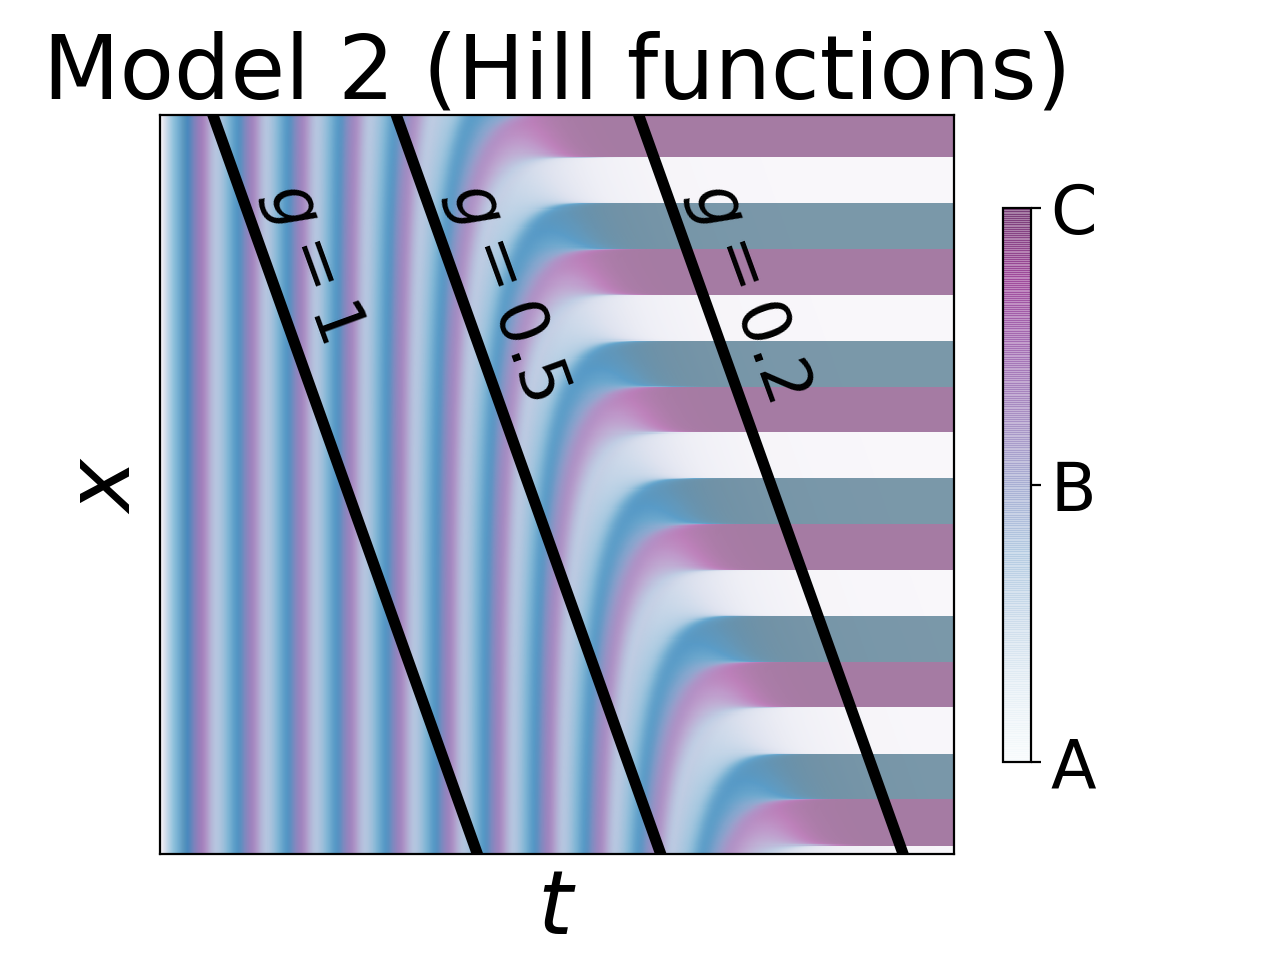

In [11]:
param["Hill_weights"] = True
param["Hill_stat"] = 0.4

init_conc = np.zeros((param["n_cells"], 3))
init_conc[:,0] = 0.75


# Model 1 (with Hill functions)
param["Hill_dyn"] = 0.6
results_m1_Hill, g_gradient_m1_Hill, times_plot_m1_Hill = integrate(init_conc, param)
plot_kymograph(results_m1_Hill, g_gradient_m1_Hill, times_plot_m1_Hill, 'Model 1 (Hill functions)', param)


# Model 2 (with Hill functions)
param["Hill_dyn"] = 0.4
results_m2_Hill, g_gradient_m2_Hill, times_plot_m2_Hill = integrate(init_conc, param)
plot_kymograph(results_m2_Hill, g_gradient_m2_Hill, times_plot_m2_Hill, 'Model 2 (Hill functions)', param)

<IPython.core.display.Javascript object>


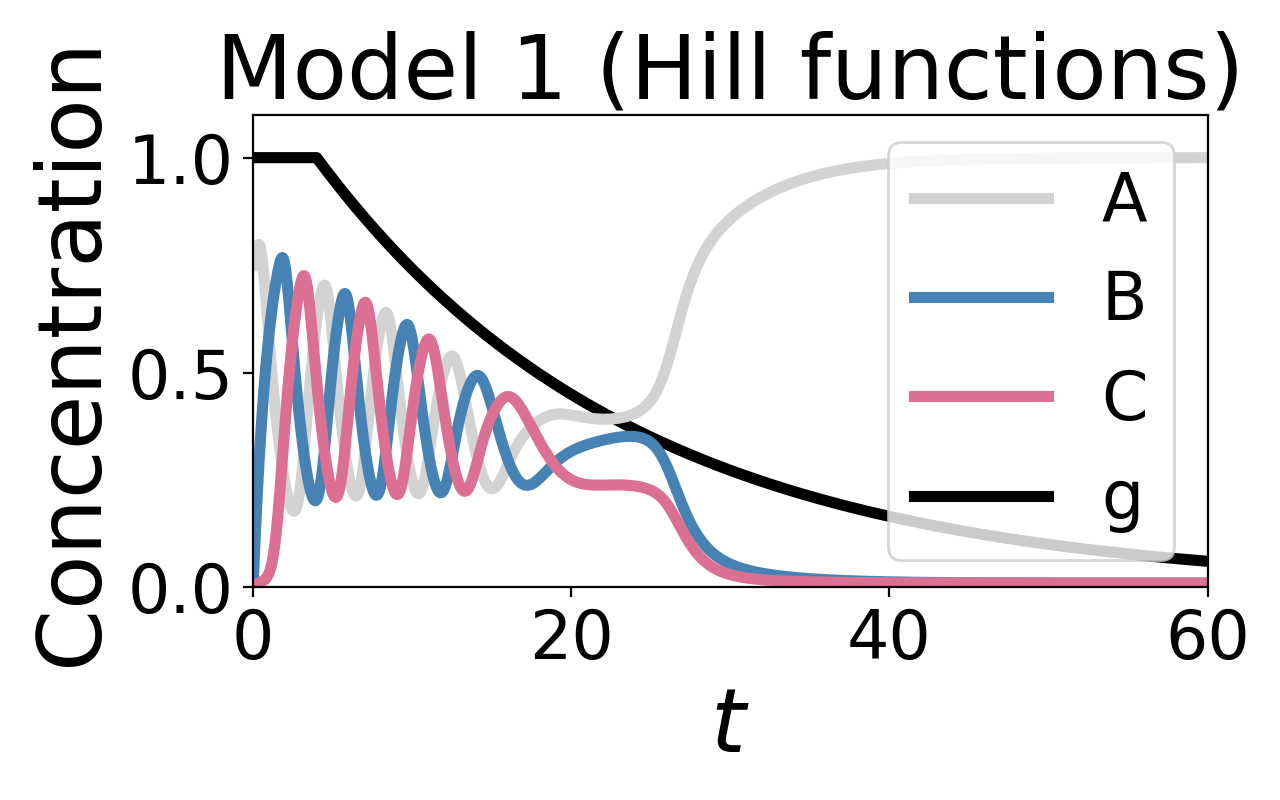

<IPython.core.display.Javascript object>


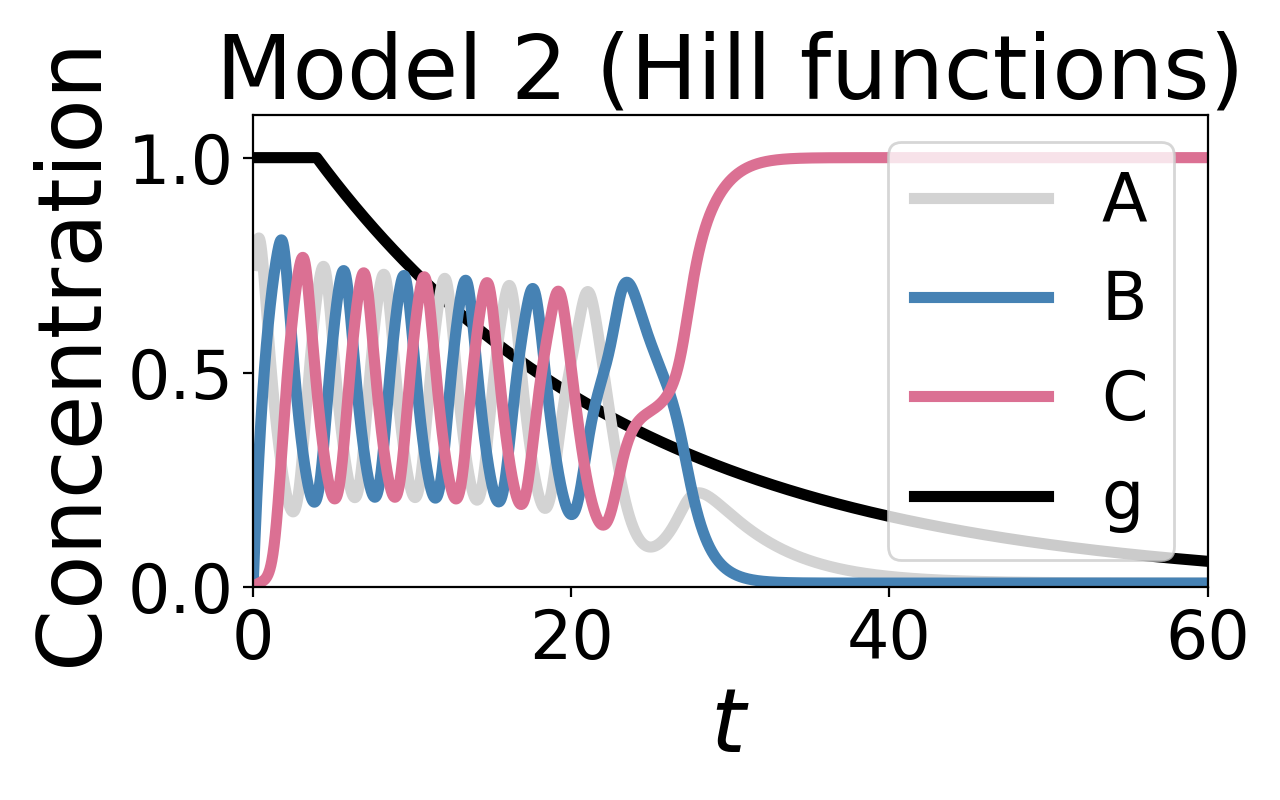

In [12]:
position_m1_Hill = 0
position_m2_Hill = 0


# Plot of the trajectory in Model 1 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_m1_Hill, results_m1_Hill[:, position_m1_Hill, 0], color='lightgrey', lw=4, label='A')
ax.plot(times_plot_m1_Hill, results_m1_Hill[:, position_m1_Hill, 1], color='steelblue', lw=4, label='B')
ax.plot(times_plot_m1_Hill, results_m1_Hill[:, position_m1_Hill, 2], color='palevioletred', lw=4, label='C')
ax.plot(times_plot_m1_Hill, g_gradient_m1_Hill[:, position_m1_Hill], color='k', lw=4, label='g', zorder=0)

# Plot options
ax.set_title('Model 1 (Hill functions)', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([0., 60.])
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()



# Plot of the trajectory in Model 2 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_m2_Hill, results_m2_Hill[:, position_m2_Hill, 0], color='lightgrey', lw=4, label='A')
ax.plot(times_plot_m2_Hill, results_m2_Hill[:, position_m2_Hill, 1], color='steelblue', lw=4, label='B')
ax.plot(times_plot_m2_Hill, results_m2_Hill[:, position_m2_Hill, 2], color='palevioletred', lw=4, label='C')
ax.plot(times_plot_m2_Hill, g_gradient_m2_Hill[:, position_m2_Hill], color='k', lw=4, label='g', zorder=0)

# Plot options
ax.set_title('Model 2 (Hill functions)', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([0., 60.])
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


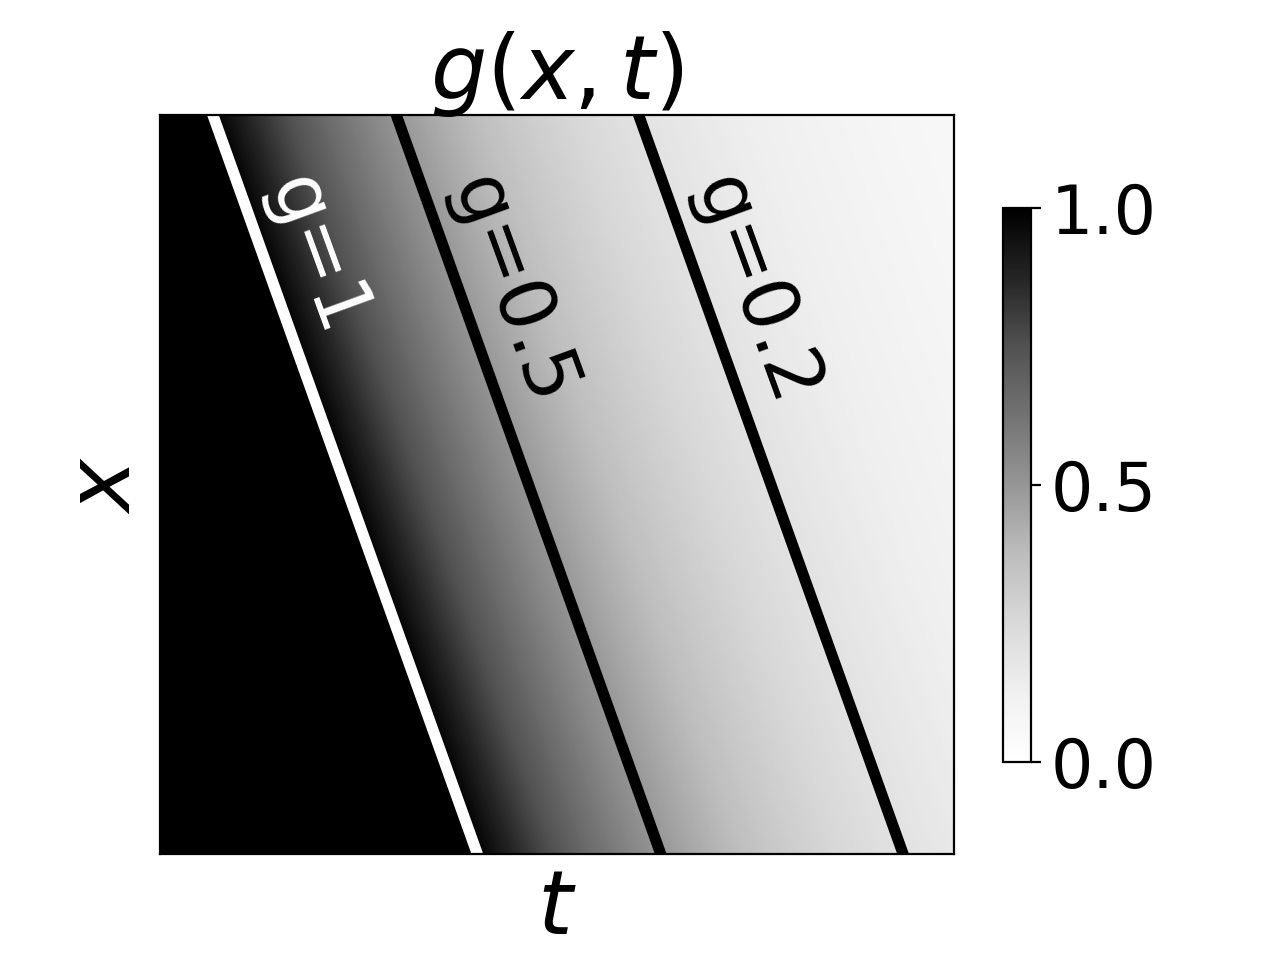

In [13]:
# Generate the kymograph of g
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_gradient_m1_Hill.transpose(), norm=norm, cmap='Greys', aspect='auto')
   
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
    
# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times_plot_m1_Hill, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times_plot_m1_Hill, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times_plot_m1_Hill, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=1', color='w', rotation=-70, fontsize=28)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=0.5', rotation=-70, color='k', fontsize=28)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=0.2', rotation=-70, color='k', fontsize=28)
    
# Other plot options  
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


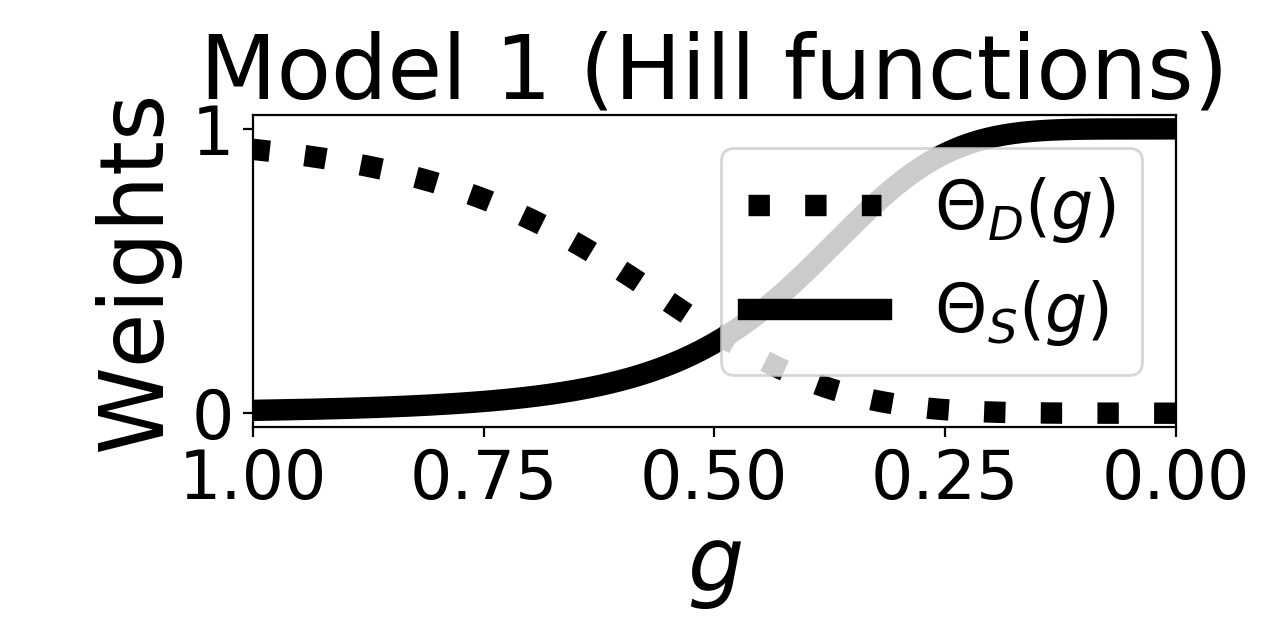

<IPython.core.display.Javascript object>


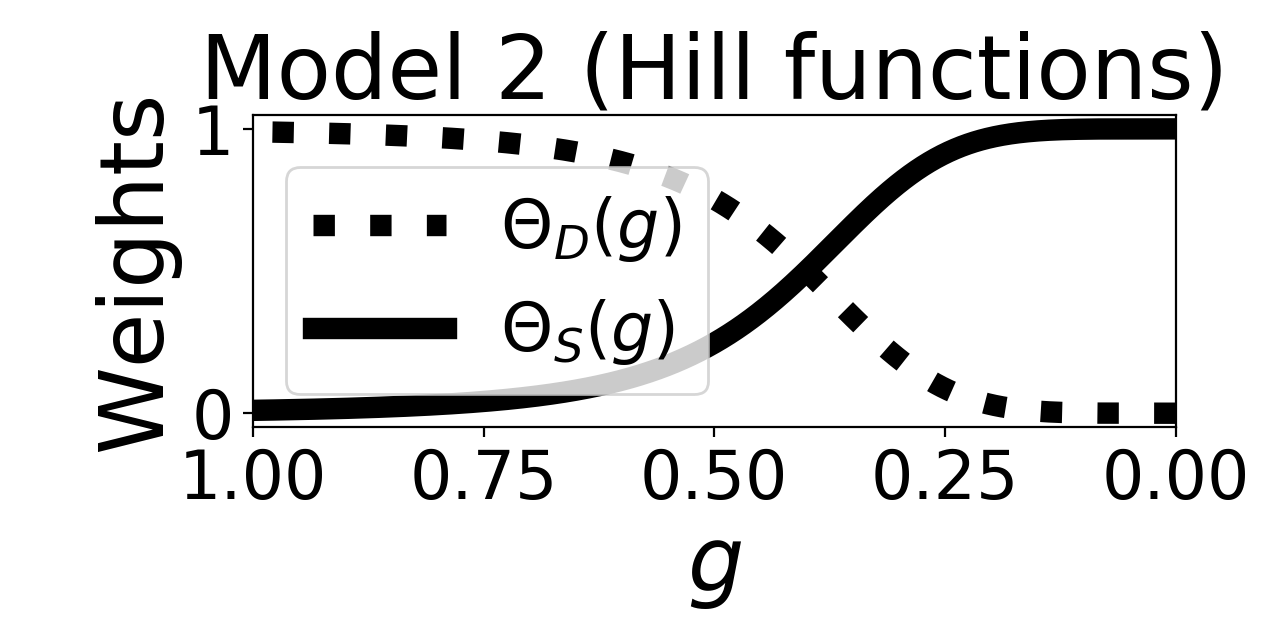

In [14]:
# Weights of Model 1 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g, (g/0.6)**5/(1.+(g/0.6)**5), c='k', ls=':', lw=7.7, label='$\Theta_D(g)$')
ax.plot(g, 1./(1.+(g/0.4)**5), c='k', ls='-', lw=7.7, label='$\Theta_S(g)$')

# Plot options
ax.set_title('Model 1 (Hill functions)', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=1).set_zorder(20)

fig.tight_layout()
fig.show()



# Weights of Model 2 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g, (g/0.4)**5/(1.+(g/0.4)**5), c='k', ls=':', lw=7.7, label='$\Theta_D(g)$')
ax.plot(g, 1./(1.+(g/0.4)**5), c='k', ls='-', lw=7.7, label='$\Theta_S(g)$')

# Plot options
ax.set_title('Model 2 (Hill functions)', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=3).set_zorder(20)

fig.tight_layout()
fig.show()

In Model 1 with Hill functions, there is a range of $g$ values for which both the weights of the dynamic and static modules are small (as in Model 1 without Hill functions). This does not happen in Model 2. In the next section, we confirm that Model 1, whether with or without Hill functions, undergoes a Hopf bifurcation, while Model 2 undergoes a SNIC bifurcation, again irrespective of the use of Hill functions or not for the weights of the static and dynamic terms.

####      

**1.7 Distribution of states at given values of $g$**

Here, we plot histograms representing the distribution of gene concentrations across the simulated array of cells for specific values of $g$. We determine the time at which $g$ starts to decrease in a given cell, and the time at which $g$ reaches 0.5 and 0.2 with the `compute_t` function that was defined in section 1.4 of this notebook. Then, we generate a plot for each version of the model (Models 1 and 2, and Models 1 and 2 with Hill functions). Each plot has three subplots, one for each value of $g$. Each subplot has three overlaid histograms, one for each gene.

In [15]:
g_hist = [1., 0.5, 0.2]
positions = np.linspace(0., 1., param["n_cells"])
gene_colors = ['lightgrey', 'steelblue', 'palevioletred']

hist_m1 = np.zeros((len(g_hist), param["n_cells"], 3))
hist_m2 = np.zeros((len(g_hist), param["n_cells"], 3))
hist_m1_Hill = np.zeros((len(g_hist), param["n_cells"], 3))
hist_m2_Hill = np.zeros((len(g_hist), param["n_cells"], 3))


for g in range(len(g_hist)):
    
    for x in range(len(positions)):
        
        time_index = int(compute_t(g_hist[g], positions[x], param)/param["dt"])
        hist_m1[g,x] = results_m1[time_index,x]
        hist_m2[g,x] = results_m2[time_index,x]
        hist_m1_Hill[g,x] = results_m1_Hill[time_index,x]
        hist_m2_Hill[g,x] = results_m2_Hill[time_index,x]

<IPython.core.display.Javascript object>


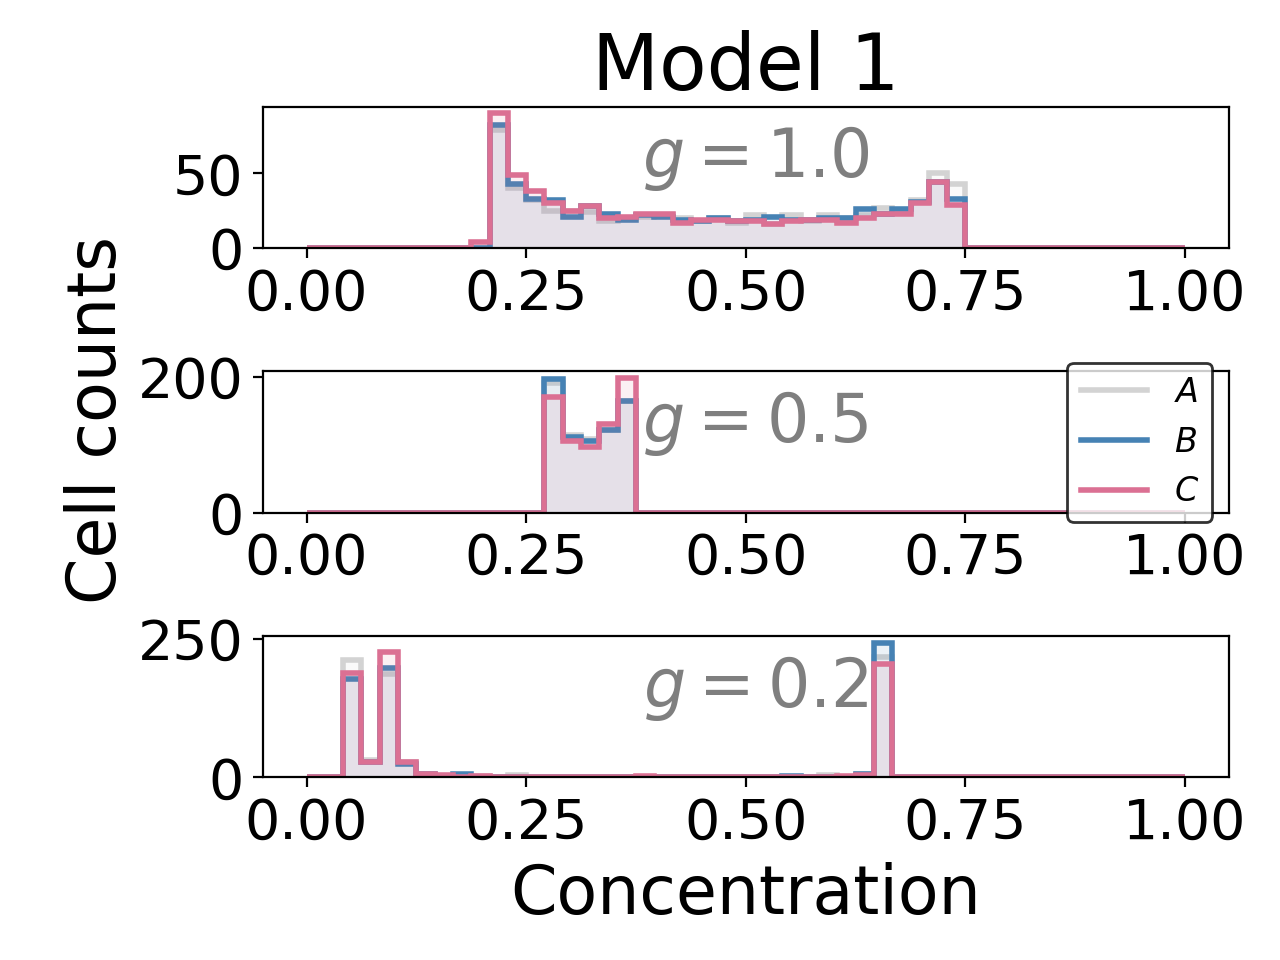

In [16]:
# 3-gene model with a supercritical Hopf bifurcation (Model 1)    
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots(len(g_hist), 2, gridspec_kw={"width_ratios":[0.01,2]})

# Histograms
for j in range(len(g_hist)):
    
    for k in range(3):
        
        ax[j,1].hist(hist_m1[j,:,k], bins=48, range=(0., 1.), histtype='bar', alpha=0.1, color=gene_colors[k])
        ax[j,1].hist(hist_m1[j,:,k], bins=48, range=(0., 1.), histtype='step', lw=2, color=gene_colors[k])
    
    # Options
    ax[j,0].axis('off')
    ax[j,1].text(0.51, 0.5, '$g=$'+str(g_hist[j]), color='tab:grey', fontsize=24, horizontalalignment='center', transform=ax[j,1].transAxes)
    ax[j,1].tick_params(labelsize=20)
#     ax[j,1].set_ylim([0., 200.])
    
# Legend
ax[1,1].plot([], [], lw=2, color=gene_colors[0], label='$A$')
ax[1,1].plot([], [], lw=2, color=gene_colors[1], label='$B$')
ax[1,1].plot([], [], lw=2, color=gene_colors[2], label='$C$')
ax[1,1].legend(loc=5, fontsize=12, edgecolor='k')  
    
# Options
ax[0,1].set_title('Model 1', fontsize=28)
ax[2,1].set_xlabel('Concentration', fontsize=24)
fig.text(0.05, 0.7, 'Cell counts', rotation='vertical', fontsize=24)
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


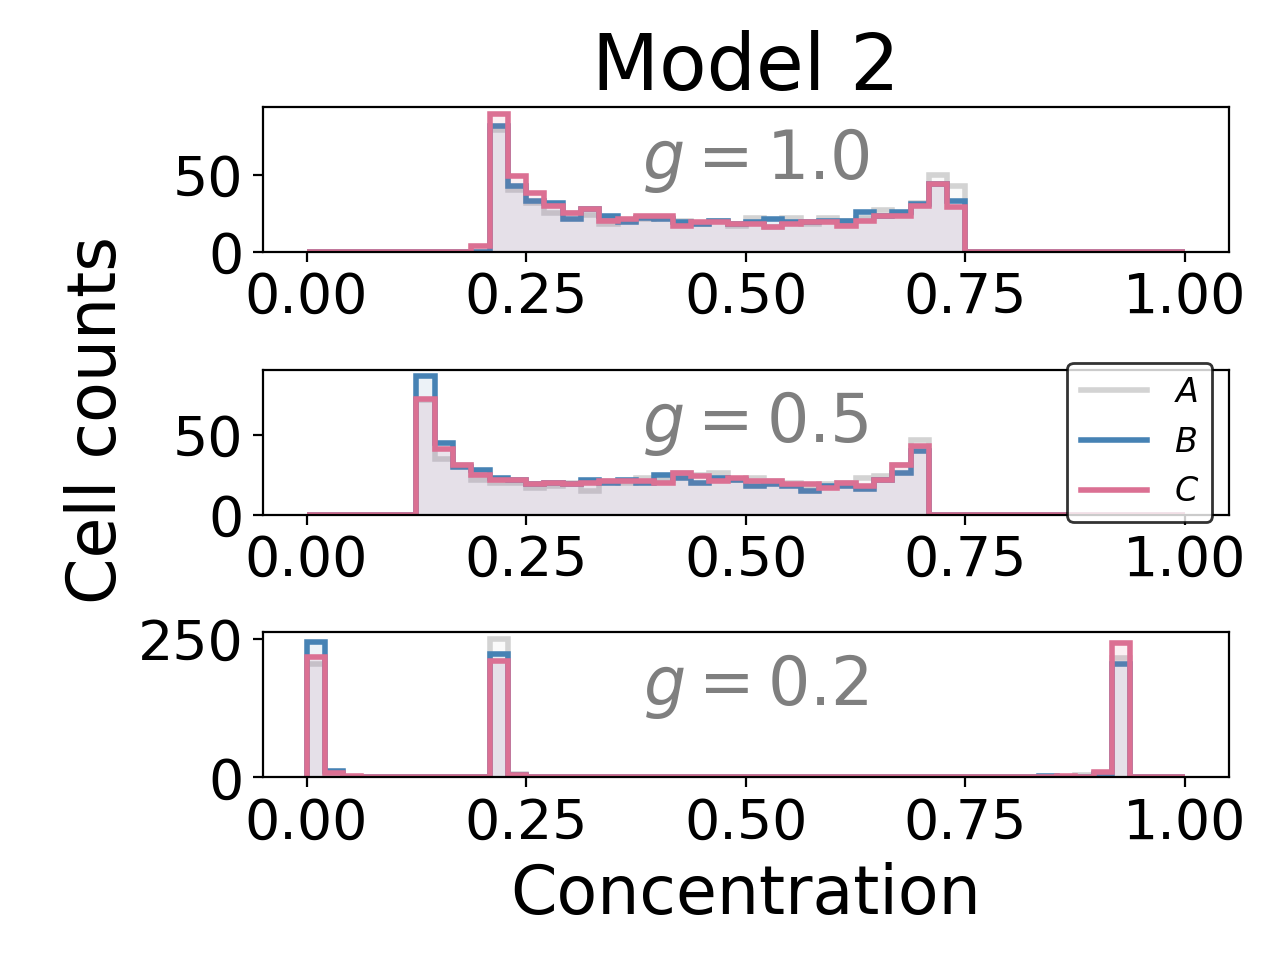

In [17]:
# 3-gene model with a SNIC bifurcation (Model 2)    
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots(len(g_hist), 2, gridspec_kw={"width_ratios":[0.01,2]})

# Histograms
for j in range(len(g_hist)):
    
    for k in range(3):
        
        ax[j,1].hist(hist_m2[j,:,k], bins=48, range=(0., 1.), histtype='bar', alpha=0.1, color=gene_colors[k])
        ax[j,1].hist(hist_m2[j,:,k], bins=48, range=(0., 1.), histtype='step', lw=2, color=gene_colors[k])
    
    # Options
    ax[j,0].axis('off')
    ax[j,1].text(0.51, 0.5, '$g=$'+str(g_hist[j]), color='tab:grey', fontsize=24, horizontalalignment='center', transform=ax[j,1].transAxes)
    ax[j,1].tick_params(labelsize=20)
#     ax[j,1].set_ylim([0., 200.])
    
# Legend
ax[1,1].plot([], [], lw=2, color=gene_colors[0], label='$A$')
ax[1,1].plot([], [], lw=2, color=gene_colors[1], label='$B$')
ax[1,1].plot([], [], lw=2, color=gene_colors[2], label='$C$')
ax[1,1].legend(loc=5, fontsize=12, edgecolor='k')  
    
# Options
ax[0,1].set_title('Model 2', fontsize=28)
ax[2,1].set_xlabel('Concentration', fontsize=24)
fig.text(0.05, 0.7, 'Cell counts', rotation='vertical', fontsize=24)
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


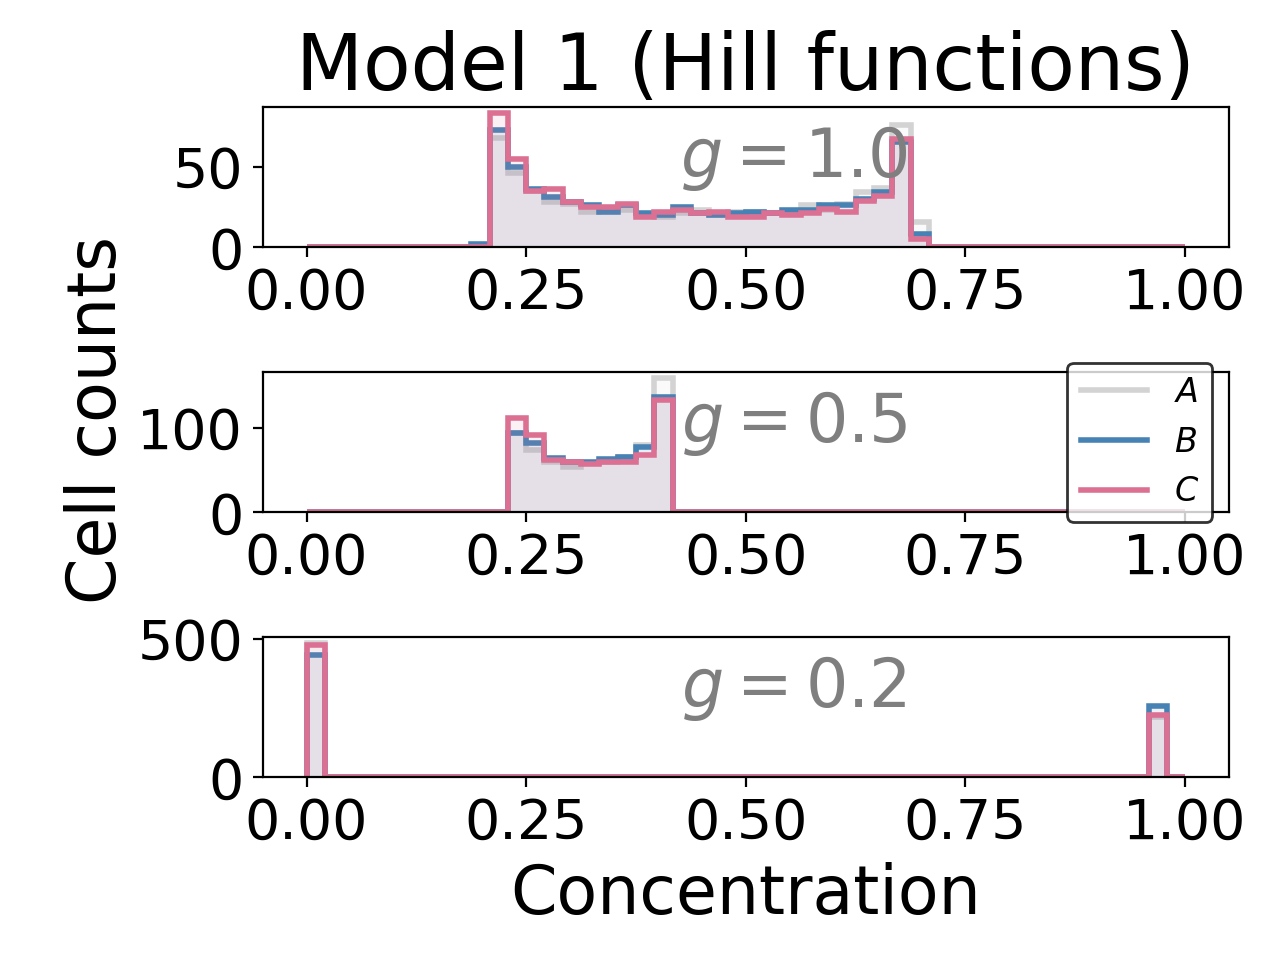

In [18]:
# 3-gene model with a supercritical Hopf bifurcation (Model 1 with Hill functions)    
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots(len(g_hist), 2, gridspec_kw={"width_ratios":[0.01,2]})

# Histograms
for j in range(len(g_hist)):
    
    for k in range(3):
        
        ax[j,1].hist(hist_m1_Hill[j,:,k], bins=48, range=(0., 1.), histtype='bar', alpha=0.1, color=gene_colors[k])
        ax[j,1].hist(hist_m1_Hill[j,:,k], bins=48, range=(0., 1.), histtype='step', lw=2, color=gene_colors[k])
    
    # Options
    ax[j,0].axis('off')
    ax[j,1].text(0.55, 0.5, '$g=$'+str(g_hist[j]), color='tab:grey', fontsize=24, horizontalalignment='center', transform=ax[j,1].transAxes)
    ax[j,1].tick_params(labelsize=20)
#     ax[j,1].set_ylim([0., 200.])
    
# Legend
ax[1,1].plot([], [], lw=2, color=gene_colors[0], label='$A$')
ax[1,1].plot([], [], lw=2, color=gene_colors[1], label='$B$')
ax[1,1].plot([], [], lw=2, color=gene_colors[2], label='$C$')
ax[1,1].legend(loc=5, fontsize=12, edgecolor='k')  
    
# Options
ax[0,1].set_title('Model 1 (Hill functions)', fontsize=28)
ax[2,1].set_xlabel('Concentration', fontsize=24)
fig.text(0.05, 0.7, 'Cell counts', rotation='vertical', fontsize=24)
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


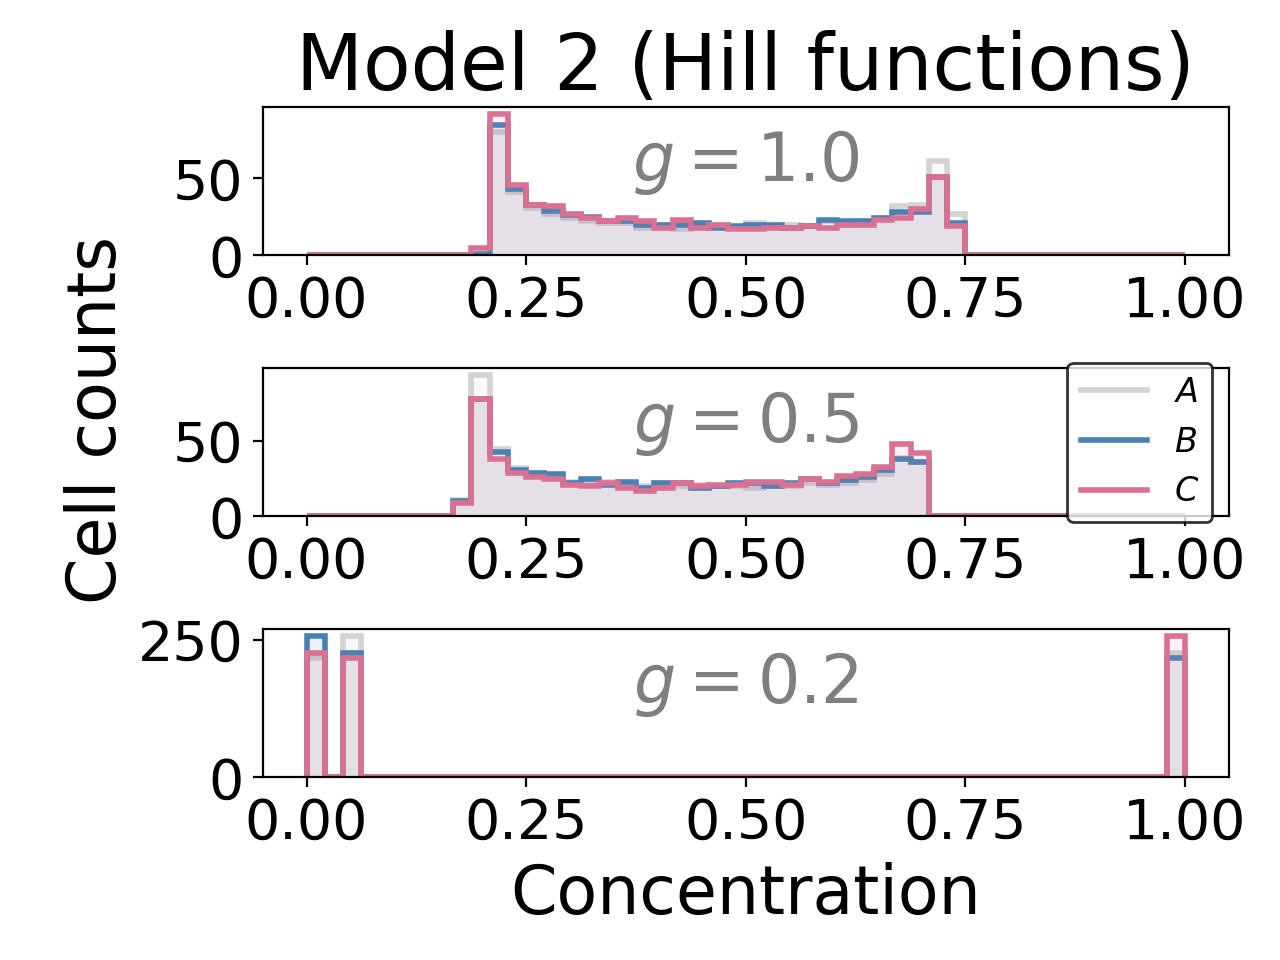

In [19]:
# 3-gene model with a SNIC bifurcation (Model 2 with Hill functions)    
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots(len(g_hist), 2, gridspec_kw={"width_ratios":[0.01,2]})

# Histograms
for j in range(len(g_hist)):
    
    for k in range(3):
        
        ax[j,1].hist(hist_m2_Hill[j,:,k], bins=48, range=(0., 1.), histtype='bar', alpha=0.1, color=gene_colors[k])
        ax[j,1].hist(hist_m2_Hill[j,:,k], bins=48, range=(0., 1.), histtype='step', lw=2, color=gene_colors[k])
    
    # Options
    ax[j,0].axis('off')
    ax[j,1].text(0.5, 0.5, '$g=$'+str(g_hist[j]), color='tab:grey', fontsize=24, horizontalalignment='center', transform=ax[j,1].transAxes)
    ax[j,1].tick_params(labelsize=20)
#     ax[j,1].set_ylim([0., 200.])
    
# Legend
ax[1,1].plot([], [], lw=2, color=gene_colors[0], label='$A$')
ax[1,1].plot([], [], lw=2, color=gene_colors[1], label='$B$')
ax[1,1].plot([], [], lw=2, color=gene_colors[2], label='$C$')
ax[1,1].legend(loc=5, fontsize=12, edgecolor='k')  
    
# Options
ax[0,1].set_title('Model 2 (Hill functions)', fontsize=28)
ax[2,1].set_xlabel('Concentration', fontsize=24)
fig.text(0.05, 0.7, 'Cell counts', rotation='vertical', fontsize=24)
        
fig.tight_layout()
fig.show()

####    

**2. Bifurcation diagrams**

For the four 3-gene models simulated above, we generate a bifurcation diagram that shows the position in gene expression space of the fixed points and limit cycles as a function of parameter $g$. We plot the concentration of gene $A$ at which stable and unstable fixed points can be found. We also plot the minimum and maximum concentration of gene $A$ that are reached by the genetic oscillations on the limit cycle. The data plotted on these bifurcation diagams was generated with the XPP AUTO software. The `.dat` data files, as well as the `.ode` files used to generate the data can be found in the `XPPAUTO_data` folder. Note that choosing the concentration of $B$ or $C$ would result in the same bifurcation diagrams, since the repression interactions between the 3 genes are completely symmetric.


####   

**2.1 Extracting the fixed points and limit cycles**

We first define functions that extract the data obtained with the XPP AUTO software. The function `extract_fixed_pts` outputs a matrix containing information about the position of the fixed points in the data file and an array of colors for the fixed points, either green for a stable fixed point or red for an unstable fixed point. Similarly, the function `extract_limit_cycles` assigns a color to each limit cycle in the data file, either grey for a stable cycle or blue for an unstable cycle.

In [20]:
def extract_fixed_pts(data_file):
    
    fixed_pts = np.genfromtxt(data_file, delimiter=' ')

    fixed_pts_color = []
    for fps in fixed_pts[:,0]:
    
        if (int(fps) == 1):    fixed_pts_color.append('tab:green')
        elif (int(fps) == 2):    fixed_pts_color.append('tab:red')
        else:
            print('ERROR: one of the points is neither a stable nor unstable equilibria.')
            break
            
    return fixed_pts, fixed_pts_color

        

def extract_limit_cycles(data_file):
    
    limit_cycles = np.genfromtxt(data_file, delimiter=' ')

    limit_cycles_color = []
    for lc in limit_cycles[:,0]:
    
        if (int(lc) == 3):    limit_cycles_color.append('k')
        elif (int(lc) == 4):    limit_cycles_color.append('tab:blue')
        else:
            print('ERROR: one of the points is neither stable nor unstable periodics.')
            break
            
    return limit_cycles, limit_cycles_color

####   

**2.2 Generating the bifurcation diagrams**

We plot the bifurcation diagrams, and indicate the bifurcation events that occur in each model.

<IPython.core.display.Javascript object>


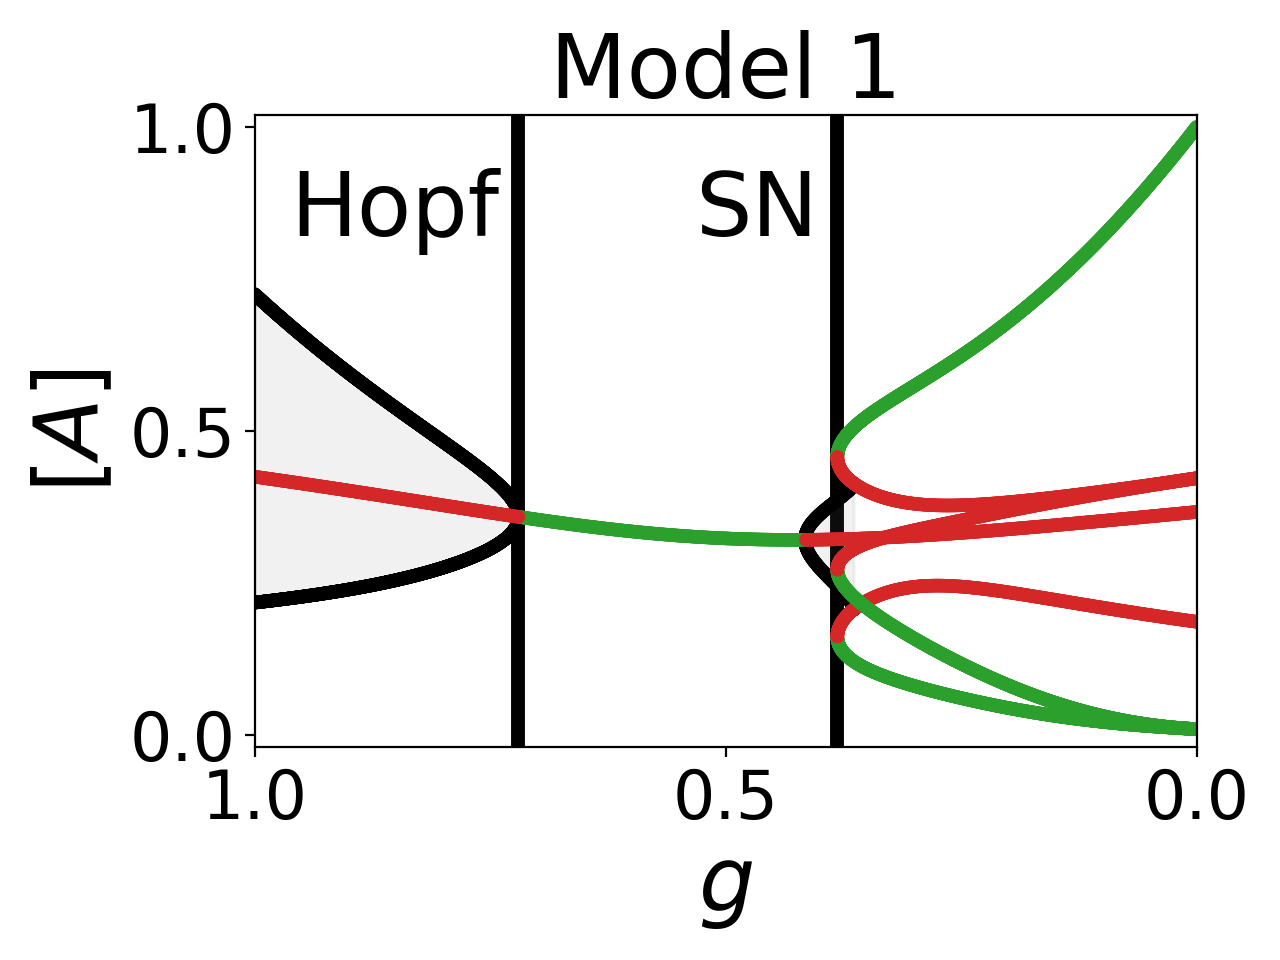

In [21]:
# Model 1

# Extract the data
fp_m1, fp_m1_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_m1_fp.dat')
lc_m1, lc_m1_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_m1_lc.dat')
g_Hopf_m1 = 0.72
g_SN_m1 = 0.382

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_m1[:178,3], lc_m1[:178,9], lc_m1[:178,6], color='tab:grey', alpha=0.1)
ax.fill_between(lc_m1[595:,3], lc_m1[595:,9], lc_m1[595:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_m1[:,3], lc_m1[:,6], s=15, color=lc_m1_color)
ax.scatter(lc_m1[:,3], lc_m1[:,9], s=15, color=lc_m1_color)

# Fixed points
ax.scatter(fp_m1[:,3], fp_m1[:,6], s=15, color=fp_m1_color)

# Bifurcations
ax.plot([g_Hopf_m1, g_Hopf_m1], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_Hopf_m1+0.02, 0.82, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN_m1, g_SN_m1], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN_m1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
    
# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


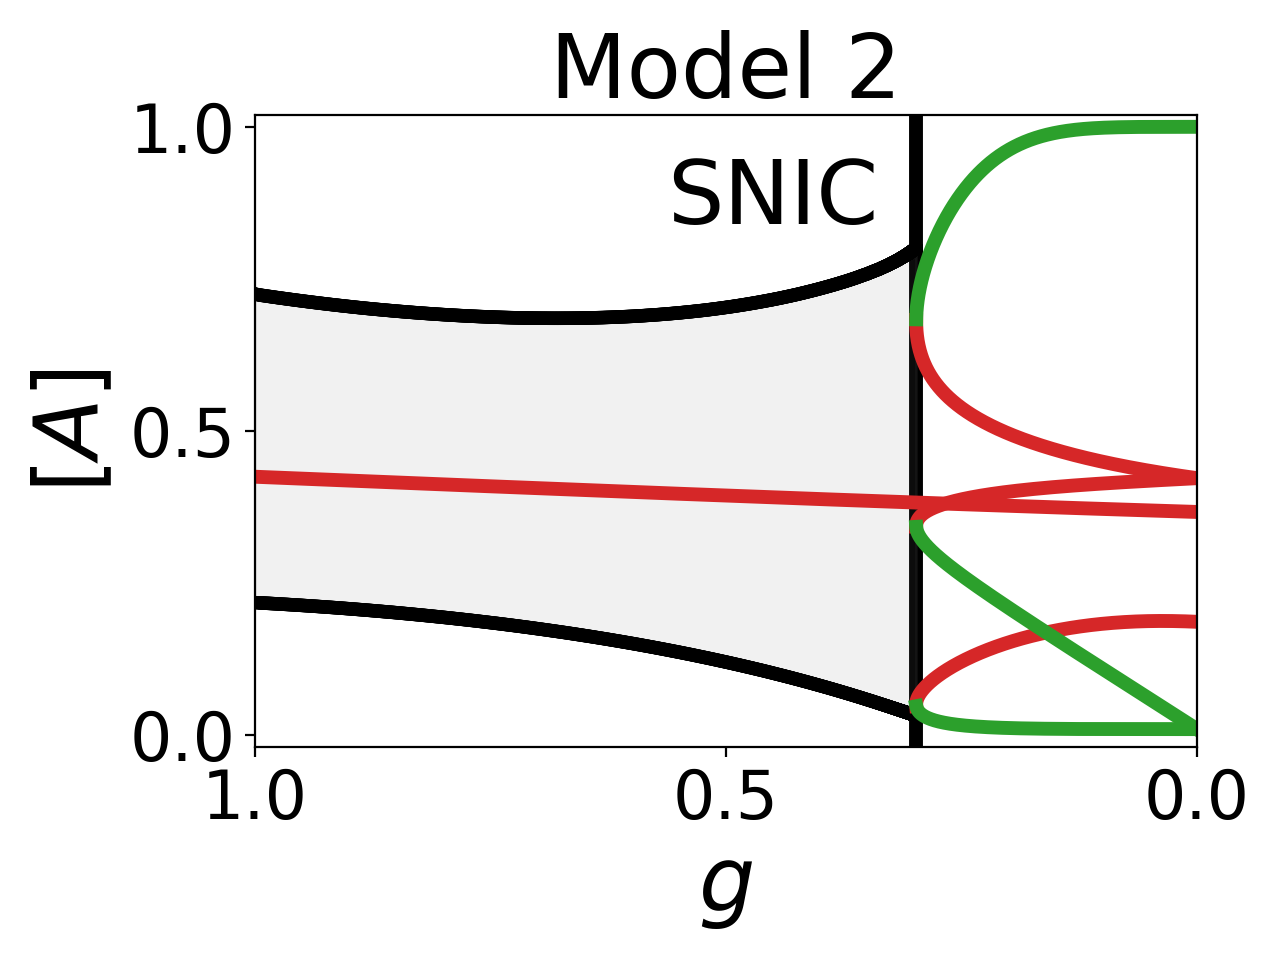

In [22]:
# Model 2

# Extract the data
fp_m2, fp_m2_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_m2_fp.dat')
lc_m2, lc_m2_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_m2_lc.dat')
g_SNIC_m2 = 0.298

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Stable limit cycles
ax.fill_between(lc_m2[:,3], lc_m2[:,9], lc_m2[:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_m2[:,3], lc_m2[:,6], s=15, color=lc_m2_color)
ax.scatter(lc_m2[:,3], lc_m2[:,9], s=15, color=lc_m2_color)

# Unstable fixed points
ax.plot(fp_m2[:1000,3], fp_m2[:1000,6], c='tab:red', ls='-', lw=5)
ax.plot(fp_m2[1630:2100,3], fp_m2[1630:2100,6], c='tab:red', ls='-', lw=5)
ax.plot(fp_m2[2720:3200,3], fp_m2[2720:3200,6], c='tab:red', ls='-', lw=5)
ax.plot(fp_m2[3825:,3], fp_m2[3825:,6], c='tab:red', ls='-', lw=5)

# Stable fixed points
ax.plot(fp_m2[2105:2720,3], fp_m2[2105:2720,6], c='tab:green', ls='-', lw=5)
ax.plot(fp_m2[1011:1630,3], fp_m2[1011:1630,6], c='tab:green', ls='-', lw=5)
ax.plot(fp_m2[3210:3825,3], fp_m2[3210:3825,6], c='tab:green', ls='-', lw=5)

# Bifurcations
ax.plot([g_SNIC_m2, g_SNIC_m2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SNIC_m2+0.04, 0.84, 'SNIC', fontsize=32, horizontalalignment='right')
    
# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


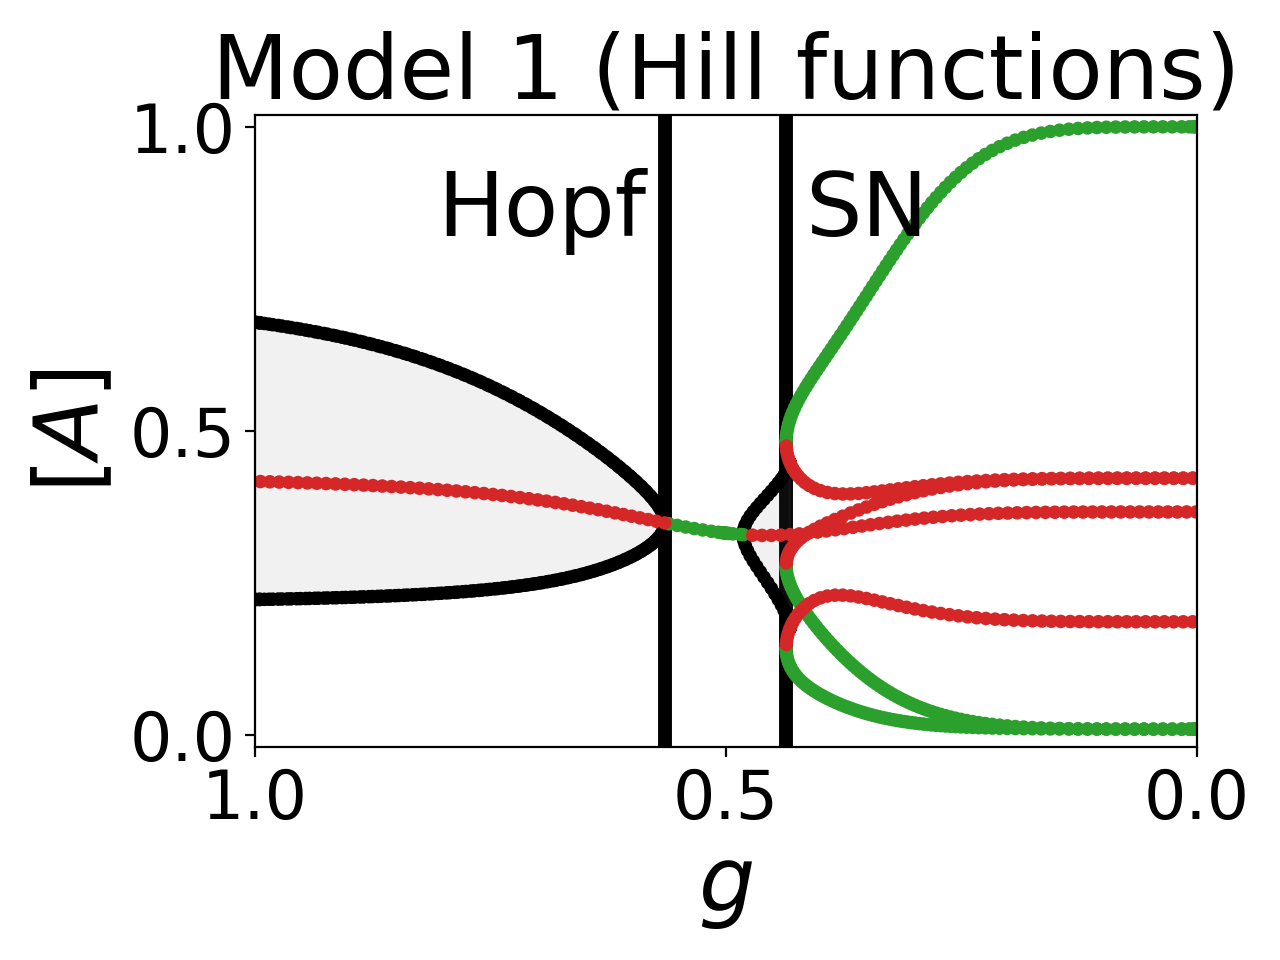

In [23]:
# Model 1 (with Hill functions)

# Extract the data
fp_m1_Hill, fp_m1_Hill_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_m1_Hill_fp.dat')
lc_m1_Hill, lc_m1_Hill_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_m1_Hill_lc.dat')
g_Hopf_m1_Hill = 0.564
g_SN_m1_Hill = 0.436

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_m1_Hill[:58,3], lc_m1_Hill[:58,9], lc_m1_Hill[:58,6], color='tab:grey', alpha=0.1)
ax.fill_between(lc_m1_Hill[120:,3], lc_m1_Hill[120:,9], lc_m1_Hill[120:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_m1_Hill[:,3], lc_m1_Hill[:,6], s=15, color=lc_m1_Hill_color)
ax.scatter(lc_m1_Hill[:,3], lc_m1_Hill[:,9], s=15, color=lc_m1_Hill_color)

# Fixed points
ax.scatter(fp_m1_Hill[:,3], fp_m1_Hill[:,6], s=15, color=fp_m1_Hill_color)

# Bifurcations
ax.plot([g_Hopf_m1_Hill, g_Hopf_m1_Hill], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_Hopf_m1_Hill+0.02, 0.82, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN_m1_Hill, g_SN_m1_Hill], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN_m1_Hill-0.02, 0.82, 'SN', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 1 (Hill functions)', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


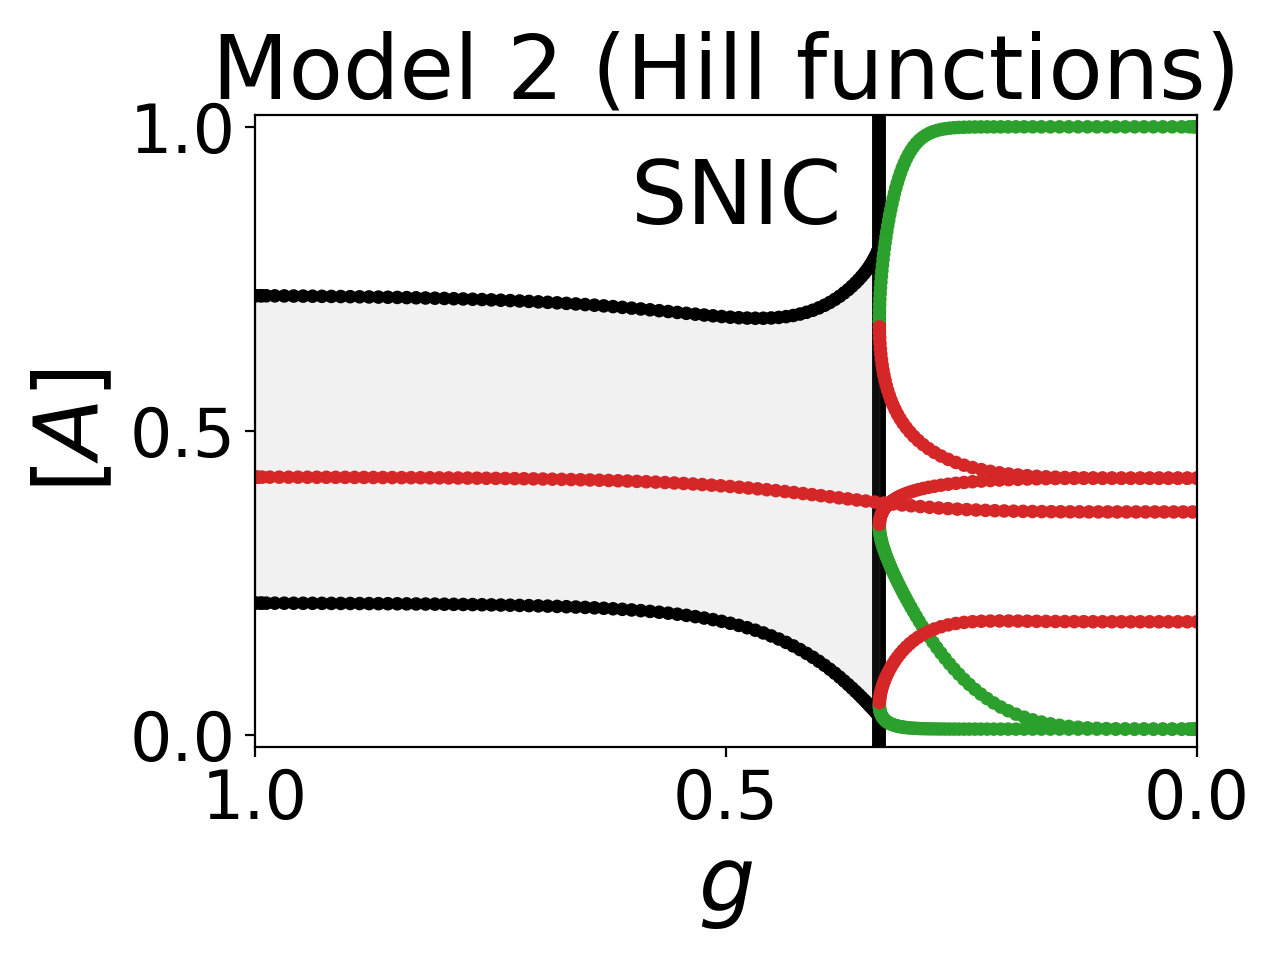

In [24]:
# Model 2 (with Hill functions)

# Extract the data
fp_m2_Hill, fp_m2_Hill_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_m2_Hill_fp.dat')
lc_m2_Hill, lc_m2_Hill_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_m2_Hill_lc.dat')
g_SNIC_m2_Hill = 0.337

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Stable limit cycles
ax.fill_between(lc_m2_Hill[:,3], lc_m2_Hill[:,9], lc_m2_Hill[:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_m2_Hill[:,3], lc_m2_Hill[:,6], s=15, color=lc_m2_Hill_color)
ax.scatter(lc_m2_Hill[:,3], lc_m2_Hill[:,9], s=15, color=lc_m2_Hill_color)

# Fixed points
ax.scatter(fp_m2_Hill[:,3], fp_m2_Hill[:,6], s=15, color=fp_m2_Hill_color)

# Bifurcations
ax.plot([g_SNIC_m2_Hill, g_SNIC_m2_Hill], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SNIC_m2_Hill+0.04, 0.84, 'SNIC', fontsize=32, horizontalalignment='right')
    
# Other plot options
ax.set_title('Model 2 (Hill functions)', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

In both versions of Model 1, the limit cycle disappears via a Hopf bifurcation at $g$ ~ 0.72 ($g$ ~ 0.56 with Hill functions), leaving only a single fixed point for intermediate values of $g$. The fixed points defining the regions of the pattern form at $g$ ~ 0.38 ($g$ ~ 0.44 with Hill functions) via saddle-node bifurcations. On the other hand, both versions of Model 2 lose their limit cycle at the same time that they form the fixed points defining the pattern, via a SNIC bifurcation at $g$ ~ 0.3 ($g$ ~ 0.34 with Hill functions).

####    


**2.3 Period and amplitude dependence on the control parameter**

In this section of the notebook, we plot the period and the amplitude as a function of $g$. Before generating the plots, we define a function that extracts the minimum and maximum concentrations reached by the oscillations on the stable limit cycles and computes the amplitude. This function also extracts the period of the oscillations on the stable limit cycle. The input is the `.dat` files obtained with XPP AUTO.

In [25]:
def extract_period_amplitude(data_file):
    
    data = np.genfromtxt(data_file, delimiter=' ')
    
    g = data[:,3]   # Array of g values
    T = data[:,5]   # Period
    
    max_A = data[:,6]
    max_B = data[:,7]
    max_C = data[:,8]
    min_A = data[:,9]
    min_B = data[:,10]
    min_C = data[:,11]
    
    A_A = max_A -min_A   # Amplitude of the concentration of A
    A_B = max_B -min_B   # Amplitude of the concentration of B
    A_C = max_C -min_C   # Amplitude of the concentration of C
    
    return np.array([g, T, A_A, A_B, A_C])

<IPython.core.display.Javascript object>


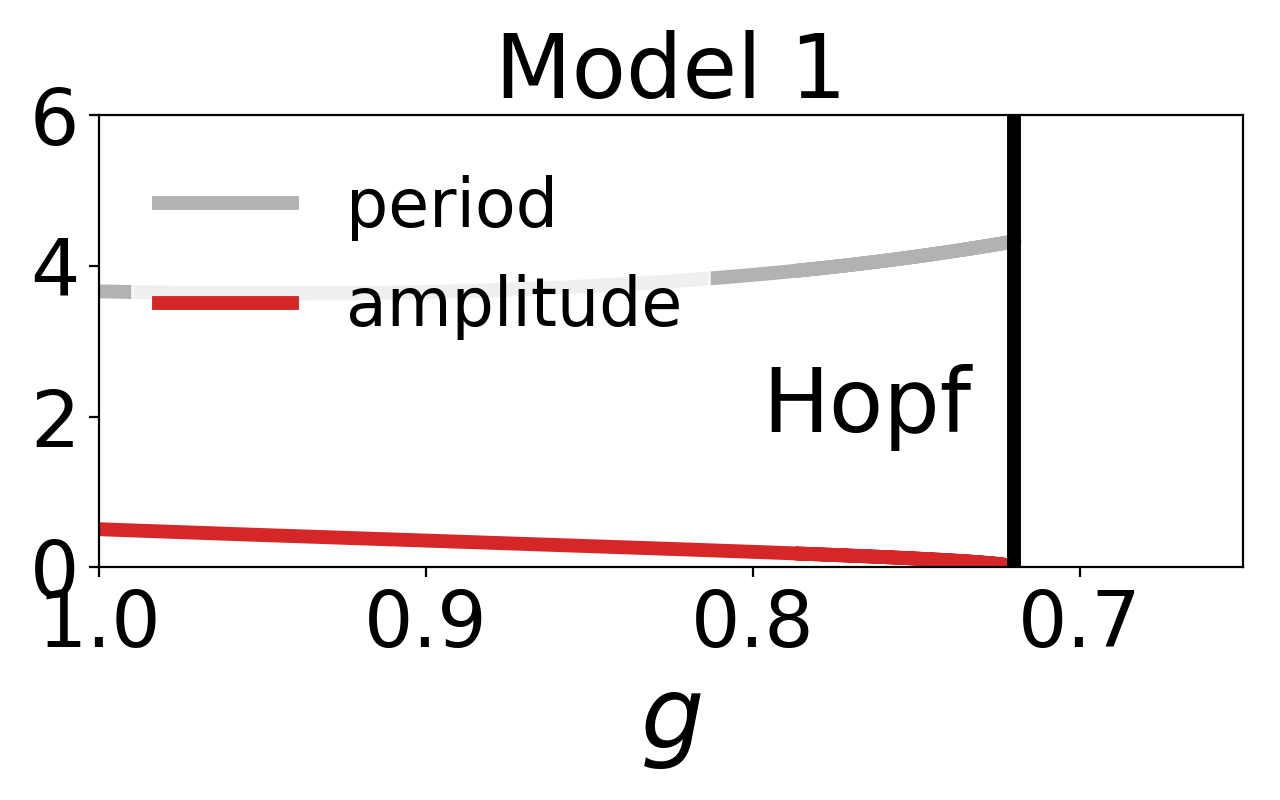

In [26]:
# Model 1
period_amplitude_m1 = extract_period_amplitude('XPPAUTO_data/3-gene_models/3-gene_m1_lc.dat')
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Period
ax.plot(period_amplitude_m1[0,500:], period_amplitude_m1[1,500:], c='k', alpha=0.3, lw=5)

# Amplitude
ax.plot(period_amplitude_m1[0,500:], period_amplitude_m1[2,500:], c='tab:red', lw=5)

# Bifurcation
ax.plot([0.72, 0.72], [0., 6.5], c='k', ls='-', lw=5, zorder=20)
ax.text(0.797, 1.8, 'Hopf', fontsize=32)

# Generate the legend
ax.plot([], c='k', alpha=0.3, lw=5, label='period')
ax.plot([], c='tab:red', lw=5, label='amplitude')
legend = ax.legend(loc=2, fontsize=24, edgecolor='w')

# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.tick_params(labelsize=28)
ax.set_xlim([1., 0.65])
ax.set_ylim([0., 6.])
ax.set_yticks([0, 2., 4., 6.])
ax.set_xlabel('$g$', fontsize=36)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


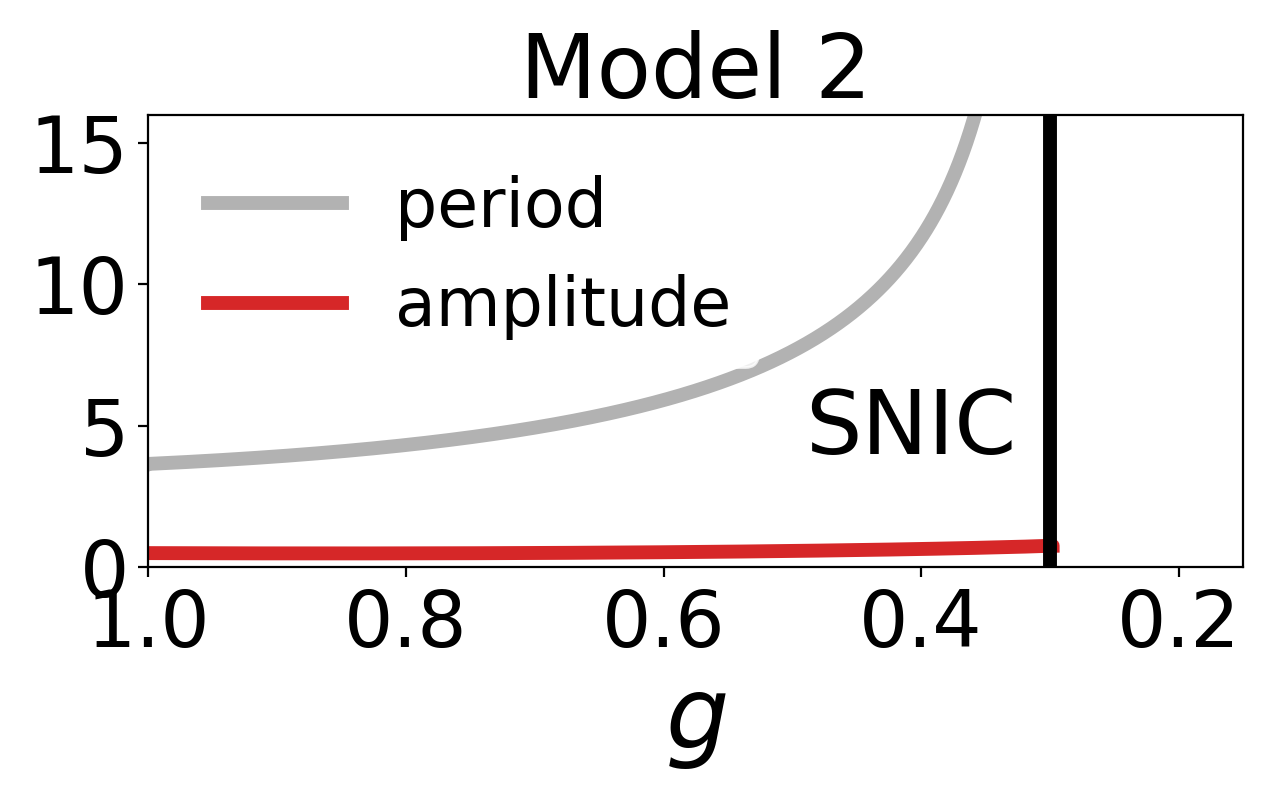

In [27]:
# Model 2
period_amplitude_m2 = extract_period_amplitude('XPPAUTO_data/3-gene_models/3-gene_m2_lc.dat')
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Period
ax.plot(period_amplitude_m2[0], period_amplitude_m2[1], c='k', alpha=0.3, lw=5)

# Amplitude
ax.plot(period_amplitude_m2[0], period_amplitude_m2[2], c='tab:red', lw=5)

# Bifurcation
ax.plot([0.3, 0.3], [0., 16.], c='k', ls='-', lw=5, zorder=20)
ax.text(0.49, 4., 'SNIC', fontsize=32)

# Generate the legend
ax.plot([], c='k', alpha=0.3, lw=5, label='period')
ax.plot([], c='tab:red', lw=5, label='amplitude')
legend = ax.legend(fontsize=24, edgecolor='w')

# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.tick_params(labelsize=28)
ax.set_xlim([1., 0.15])
ax.set_ylim([0., 16.])
ax.set_yticks([0., 5., 10., 15.])
ax.set_xticks([1., 0.8, 0.6, 0.4, 0.2])
ax.set_xlabel('$g$', fontsize=36)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


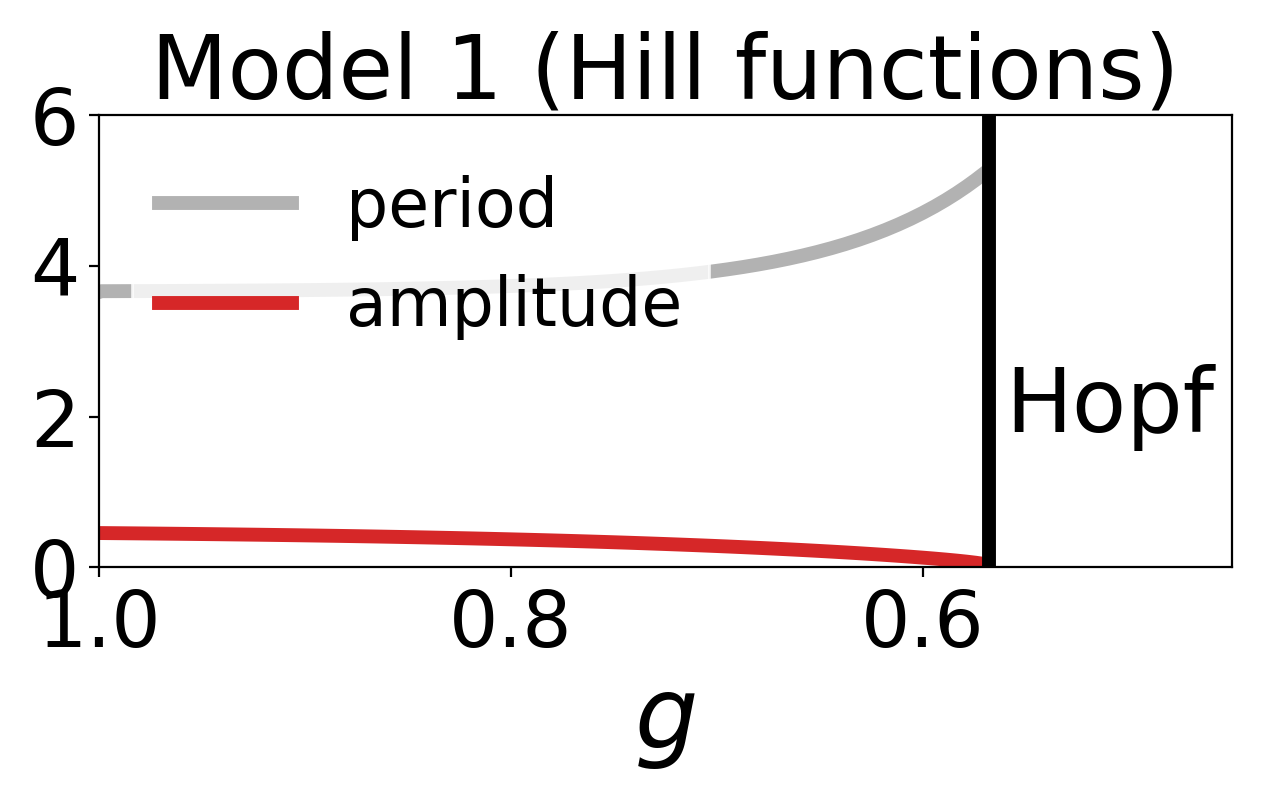

In [28]:
# Model 1 (with Hill functions)
period_amplitude_m1_Hill = extract_period_amplitude('XPPAUTO_data/3-gene_models/3-gene_m1_Hill_lc.dat')
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Period
ax.plot(period_amplitude_m1_Hill[0,:58], period_amplitude_m1_Hill[1,:58], c='k', alpha=0.3, lw=5)

# Amplitude
ax.plot(period_amplitude_m1_Hill[0,:58], period_amplitude_m1_Hill[2,:58], c='tab:red', lw=5)

# Bifurcation
ax.plot([0.568, 0.568], [0., 6.5], c='k', ls='-', lw=5, zorder=20)
ax.text(0.56, 1.8, 'Hopf', fontsize=32)

# Generate the legend
ax.plot([], c='k', alpha=0.3, lw=5, label='period')
ax.plot([], c='tab:red', lw=5, label='amplitude')
legend = ax.legend(loc=2, fontsize=24, edgecolor='w')

# Other plot options
ax.set_title('Model 1 (Hill functions)', fontsize=32)
ax.tick_params(labelsize=28)
ax.set_xlim([1., 0.45])
ax.set_ylim([0., 6.])
ax.set_yticks([0, 2., 4., 6.])
ax.set_xlabel('$g$', fontsize=36)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


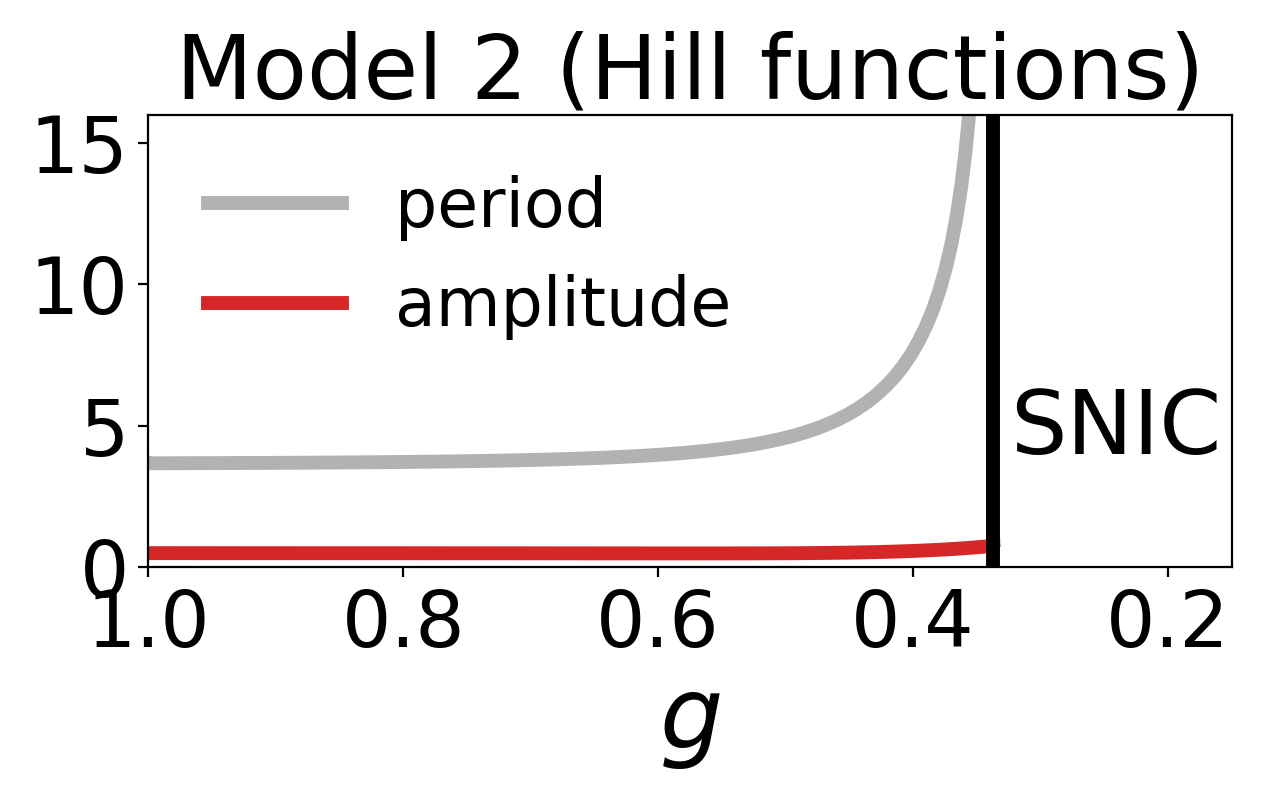

In [29]:
# Model 2 (with Hill functions)
period_amplitude_m2_Hill = extract_period_amplitude('XPPAUTO_data/3-gene_models/3-gene_m2_Hill_lc.dat')
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Period
ax.plot(period_amplitude_m2_Hill[0], period_amplitude_m2_Hill[1], c='k', alpha=0.3, lw=5)

# Amplitude
ax.plot(period_amplitude_m2_Hill[0], period_amplitude_m2_Hill[2], c='tab:red', lw=5)

# Bifurcation
ax.plot([0.337, 0.337], [0., 16.], c='k', ls='-', lw=5, zorder=20)
ax.text(0.324, 4., 'SNIC', fontsize=32)

# Generate the legend
ax.plot([], c='k', alpha=0.3, lw=5, label='period')
ax.plot([], c='tab:red', lw=5, label='amplitude')
legend = ax.legend(fontsize=24, edgecolor='w')

# Other plot options
ax.set_title('Model 2 (Hill functions)', fontsize=32)
ax.tick_params(labelsize=28)
ax.set_xlim([1., 0.15])
ax.set_ylim([0., 16.])
ax.set_yticks([0., 5., 10., 15.])
ax.set_xticks([1., 0.8, 0.6, 0.4, 0.2])
ax.set_xlabel('$g$', fontsize=36)

fig.tight_layout()
fig.show()

In both versions of Model 1, the amplitude smoothly reaches 0, and the oscillations die with a finite period, as expected for a Hopf bifurcation. On the other hand, in both versions of Model 2 the amplitude stays non-zero and the period smoothly reaches infinity, as expected for a SNIC bifurcation.

####       


**3. Peak-to-peak frequency**

In the following section, we compute the peak-to-peak frequency of the oscillations for Models 1 and 2.

####     


**3.1 Finding the peaks**

In the next code cell, we identify the positions at which the concentration of $A$ has a maximum. We repeat the procedure for each time point and store the results in the `peaks_m1` and `peaks_m2` arrays.

In [30]:
# Compute the time indices at which new cells are added
n_cells = param["n_cells"]
ap_positions = np.linspace(0.0, 1.0, n_cells)
t_index_new_cell = ap_positions/param["v"]/param["dt"]
t_index_new_cell = t_index_new_cell.astype('int')


# Model 1
peaks_m1 = [[] for k in range(len(times_plot_m1))]

# Remove the part of the kymograph that contains formed somites
results_p2p_m1 = results_m1.copy()
for k in range(n_cells):
    results_p2p_m1[t_index_new_cell[k]+2900:,k,0] = 20.

# Find the peaks      
for t_index in range(len(times_plot_m1)):
    
    for cell_index in range(2, n_cells-1):
        
        if (results_p2p_m1[t_index,cell_index,0] > results_p2p_m1[t_index,cell_index-1,0]
        and results_p2p_m1[t_index,cell_index,0] > results_p2p_m1[t_index,cell_index+1,0]):
            
            peaks_m1[t_index].append(cell_index)
            
       
    
# Model 2
peaks_m2 = [[] for k in range(len(times_plot_m2))]

# Remove the part of the kymograph that contains formed somites
results_p2p_m2 = results_m2.copy()
for k in range(n_cells):
    results_p2p_m2[t_index_new_cell[k]+2900:,k,0] = 20.

# Find the peaks      
for t_index in range(len(times_plot_m2)):
    
    for cell_index in range(2, n_cells-1):
        
        if (results_p2p_m2[t_index,cell_index,0] > results_p2p_m2[t_index,cell_index-1,0]
        and results_p2p_m2[t_index,cell_index,0] > results_p2p_m2[t_index,cell_index+1,0]):
            
            peaks_m2[t_index].append(cell_index)

####      

**3.2 Computing the peak-to-peak frequency**

We use equation 2 from [1] to compute the peak-to-peak frequency for both Models 1 and 2.

[1] Giudicelli, F., Özbudak, E. M., Wright, G. J., & Lewis, J. (2007). Setting the tempo in development: an investigation of the zebrafish somite clock mechanism. *PLoS biology,* 5(6).

In [31]:
# Model 1

# Compute the length (i.e. number of time points) of the oscillations in the posterior PSM
peaks_last_m1 = []  

for j in range(1, len(results_p2p_m1)-1):
        
        if (results_p2p_m1[j,-1,0] > results_p2p_m1[j-1,-1,0]
        and results_p2p_m1[j,-1,0] > results_p2p_m1[j+1,-1,0]):
            
            peaks_last_m1.append(j)
            
cycles_last_m1 = [peaks_last_m1[k+1]-peaks_last_m1[k] for k in range(len(peaks_last_m1)-1)]            
cycle_length_m1 = cycles_last_m1[2]


# Compute the peak-to-peak wavelength
psm_length = int(724*n_cells/500)
new_cell_index = np.array([int(k*(0.25*n_cells/500)) for k in range(len(peaks_m1))])

p2p_wavelength_m1 = []
p2p_position_m1 = []

for t_index in range(len(peaks_m1)):
         
    if(len(peaks_m1[t_index]) > 1):
    
        for j in range(len(peaks_m1[t_index])-1):
        
            p2p_wavelength_m1.append(peaks_m1[t_index][j+1]-peaks_m1[t_index][j])
            
            posterior = (new_cell_index[t_index] -peaks_m1[t_index][j+1])/psm_length
            anterior = (new_cell_index[t_index] -peaks_m1[t_index][j])/psm_length
            p2p_position_m1.append(0.5*(posterior+anterior))
            
p2p_wavelength_m1 = np.array(p2p_wavelength_m1)
p2p_position_m1 = np.array(p2p_position_m1)


# Numerical peak-to-peak frequency
u_m1 = param["v"]*cycle_length_m1*param["dt"]*n_cells
p2p_freq_m1 = 1.-u_m1/p2p_wavelength_m1



# Theoretical normalized frequency retrieved from XPP AUTO
temp_index = 635
freq_m1 = 2.*np.pi/period_amplitude_m1[1,temp_index:]
norm_freq_m1 = freq_m1/freq_m1[-1]

g_array_m1 = period_amplitude_m1[0,temp_index:]
ap_positions_m1 = (1. -compute_x(g_array_m1, t_index_new_cell[-1]*param['dt'], param))*n_cells/psm_length

In [32]:
# Model 2

# Compute the length (i.e. number of time points) of the oscillations in the posterior PSM
peaks_last_m2 = []  

for j in range(1, len(results_p2p_m2)-1):
        
        if (results_p2p_m2[j,-1,0] > results_p2p_m2[j-1,-1,0]
        and results_p2p_m2[j,-1,0] > results_p2p_m2[j+1,-1,0]):
            
            peaks_last_m2.append(j)
            
cycles_last_m2 = [peaks_last_m2[k+1]-peaks_last_m2[k] for k in range(len(peaks_last_m2)-1)]            
cycle_length_m2 = cycles_last_m2[2]


# Compute the peak-to-peak wavelength
psm_length = int(724*n_cells/500)
new_cell_index = np.array([int(k*(0.25*n_cells/500)) for k in range(len(peaks_m2))])

p2p_wavelength_m2 = []
p2p_position_m2 = []

for t_index in range(len(peaks_m2)):
         
    if(len(peaks_m2[t_index]) > 1):
    
        for j in range(len(peaks_m2[t_index])-1):
        
            p2p_wavelength_m2.append(peaks_m2[t_index][j+1]-peaks_m2[t_index][j])
            
            posterior = (new_cell_index[t_index] -peaks_m2[t_index][j+1])/psm_length
            anterior = (new_cell_index[t_index] -peaks_m2[t_index][j])/psm_length
            p2p_position_m2.append(0.5*(posterior+anterior))
            
p2p_wavelength_m2 = np.array(p2p_wavelength_m2)
p2p_position_m2 = np.array(p2p_position_m2)


# Numerical peak-to-peak frequency
u_m2 = param["v"]*cycle_length_m2*param["dt"]*n_cells
p2p_freq_m2 = 1.-u_m2/p2p_wavelength_m2



# Theoretical normalized frequency retrieved from XPP AUTO
freq_m2 = 2.*np.pi/period_amplitude_m2[1]
norm_freq_m2 = freq_m2/freq_m2[0]

g_array_m2 = period_amplitude_m2[0]
ap_positions_m2 = (1. -compute_x(g_array_m2, t_index_new_cell[-1]*param['dt'], param))*n_cells/psm_length

####     

**3.3 Generating the plot of the peak-to-peak frequency**

We plot the numerical results for both models, as well as the theoretical frequency computed from the data obtaned with the XPP AUTO software.

<IPython.core.display.Javascript object>


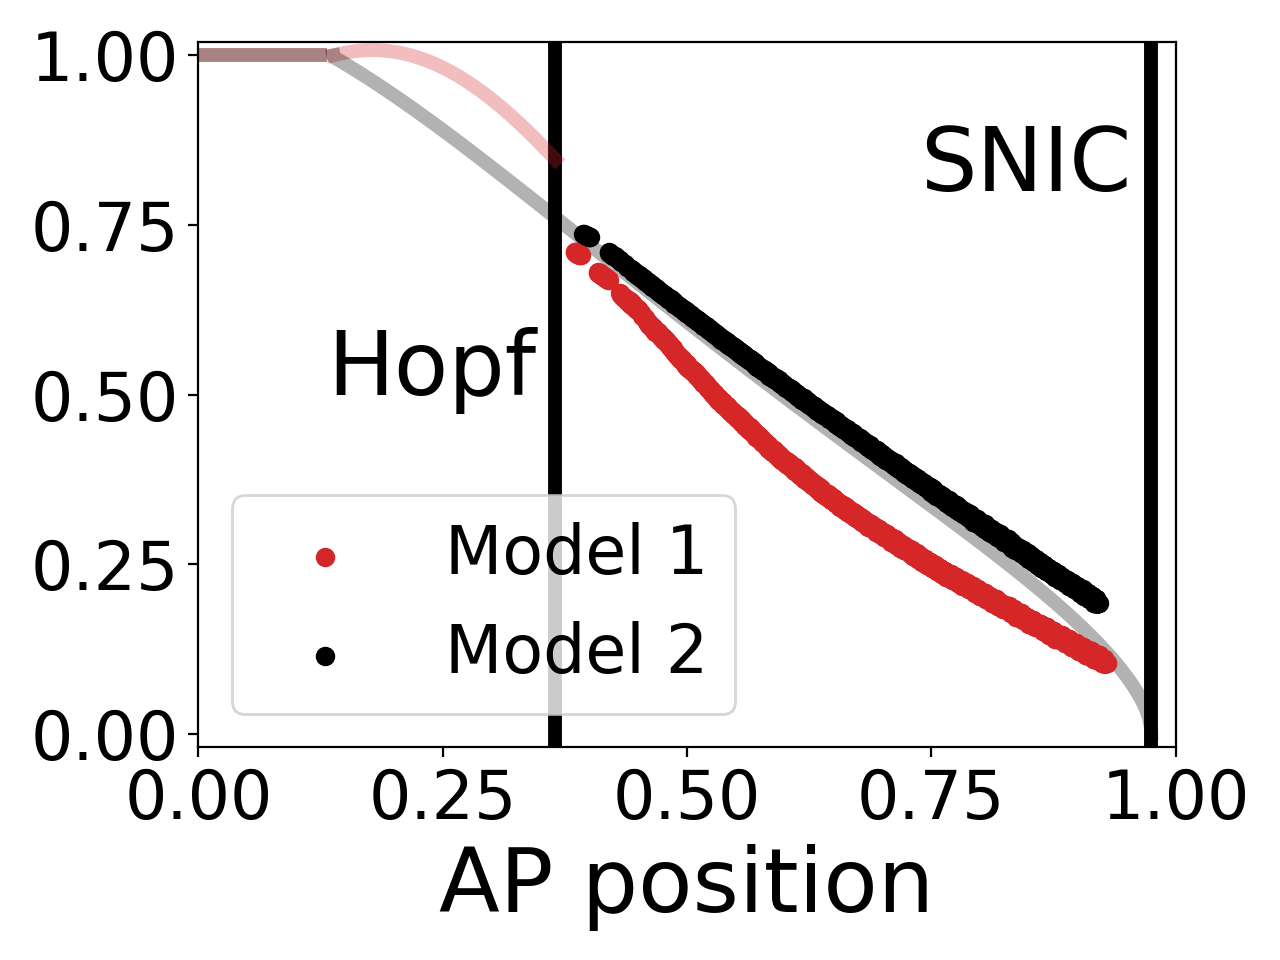

In [33]:
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Theoretical frequency obtained with XPP AUTO
ax.plot(ap_positions_m1, norm_freq_m1, c='tab:red', alpha=0.3, lw=5)
ax.plot([0., ap_positions_m1[-1]-0.014], [1., 1.], c='tab:red', alpha=0.3, lw=5)
ax.plot(ap_positions_m2, norm_freq_m2, c='k', alpha=0.3, lw=5)
ax.plot([0., ap_positions_m2[0]-0.014], [1., 1.], c='k', alpha=0.3, lw=5)

# Numerical peak-to-peak frequency
ax.scatter(p2p_position_m1, p2p_freq_m1, c='tab:red', zorder=10, label='Model 1')
ax.scatter(p2p_position_m2, p2p_freq_m2, c='k', zorder=10, label='Model 2')

# Bifurcation events
ax.plot([ap_positions_m1[0], ap_positions_m1[0]], [-0.02,1.02], c='k', lw=5, zorder=0)
ax.text(ap_positions_m1[0]-0.02, 0.5, 'Hopf', horizontalalignment='right', fontsize=32)
ax.plot([ap_positions_m2[-1], ap_positions_m2[-1]], [-0.02,1.02], c='k', lw=5, zorder=0)
ax.text(ap_positions_m2[-1]-0.02, 0.8, 'SNIC', horizontalalignment='right', fontsize=32)

# Other plot options
ax.set_xlim([0., 1.])
ax.set_ylim([-0.02,1.02])
ax.set_xlabel('AP position', fontsize=32)
# ax.set_ylabel('Normalized peak-to-peak frequency', fontsize=24)
ax.legend(loc=3, fontsize=24)
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()